# PROJECT 2

NON-SUPERVISED MODEL - SOM ANN

# INTRODUCTION

## Objetives

- Select at least two datasets over 5 dimensions and multiple classes
- Apply an unsupervised neural model
- Evaluate the patterns detected in each cluster (clusters / outliers, etc.)
- Evaluate the homogeneity of the groups
- Vary model parameters (grid, rates, number of neurons, etc.)

## Kohonen networks

For the project, the Kohonem or Self-Organizing Maps (SOM) network was selected. In this type of network, the algorithm tries to self-organize based on the similarities between the elements of the input data of the network. The network identifies common features and groups the patterns across the domain of input patterns.

The network parameters that are used in this work are:

- grid variation: represents the number of neurons in the network.

- variation of sigma: sigma denotes the radius of the network at a given time and is used to find the neighborhood of the winning neuron.

- learning rate: it is a factor that controls the size of the vector during learning in the sound network. It defines the size of the neighborhood of the winning neuron, as well as the intensity of adjustments applied by the algorithm during training.

- training iterations: represent the epochs, the training repetition steps.

## Dataset Digits

The Digits dataset consists of 8x8 pixel images of digits. The images attribute of the dataset stores 8x8 matrices of grayscale values for each image. It has 10 classes (digits from 0 to 9) and 64 dimensions (8x8 pixels).

In [1]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

## Dataset Wine

The Wine dataset contains the results of a chemical analysis of wines grown in the same region of Italy by three different growers. There are thirteen different measures for different constituents found in the three types of wine (13 dimensions and 3 classes).

In [2]:
from sklearn.datasets import load_wine
wine = load_wine()
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

## Libraries

In [22]:
from minisom import MiniSom
import numpy as np
import pandas as pd
import seaborn as sns
from plotnine import *
from io import StringIO
import umap
import sklearn.datasets
from sklearn.datasets import load_digits
from sklearn.datasets import load_wine
from sklearn.preprocessing import scale
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.patches import RegularPolygon, Ellipse
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D
%matplotlib inline
np.random.seed(123)

In [23]:
sns.set(style='white', context='notebook', rc={'figure.figsize': (11, 6)})

## Auxiliary functions

In [75]:
def umatrix(som_model, use_colorbar=True, transpose=False, **kwargs):
    distance_map = som_model.distance_map()

    if transpose:
        distance_map = distance_map.T[::-1]

    im = plt.imshow(distance_map, **kwargs)
    if use_colorbar:
        plt.colorbar(im)


def print_error(som_model, data) -> None:
    for method in ['quantization_error', 'topographic_error']:
        print(f'{method}: {getattr(som_model, method)(data)}')


def manual_random_training(som_model, data, max_iter) -> pd.DataFrame:
    errors = {'qerror': [], 'terror': []}

    for idx in range(max_iter):
        data_random = data[np.random.randint(len(data))]

        som_model.update(data_random, som_model.winner(data_random), idx,
                         max_iter)

        errors['qerror'].append(som_model.quantization_error(data))
        errors['terror'].append(som_model.topographic_error(data))
    return pd.DataFrame(errors)


def hitmap(som_model, data, use_colorbar=True, transpose=False, **kwargs):
    frequencies = som_model.activation_response(data).astype(int)
    if transpose:
        frequencies = frequencies.T[::-1]
    im = plt.imshow(frequencies, **kwargs)
    if use_colorbar:
        plt.colorbar(im)
    for (i, j), value in np.ndenumerate(frequencies):
        plt.text(j,
                 i,
                 value,
                 verticalalignment='center',
                 horizontalalignment='center')


def heatmap(som_model, feature_names, grid_spec, use_colorbar=True, **kwargs):
    weights = som_model.get_weights()
    for i, fname in enumerate(feature_names):
        plt.subplot(*grid_spec, i + 1)
        plt.title(fname)
        im = plt.imshow(weights[:, :, i], **kwargs)
        if use_colorbar:
            plt.colorbar(im)


def plot_uma_hit_hea(som_model: 'minisom.MiniSom', 
                     data: 'sklearn.utils.Bunch',
                     colu,
                     **kwargs) -> None:
    plt.figure(dpi=120, figsize=(12, 11))

    plt.subplot(2, 2, 1)
    umatrix(som_model, cmap='Reds')
    plt.title('U-Matrix')

    plt.subplot(2, 2, 2)
    hitmap(som_model, data.data, cmap='Reds')
    plt.title('hitmap')

    #grid_shape = som_model.get_weights().shape[0:2]

    plt.figure(dpi=120, figsize=(12, 11))
    heatmap(som_model, data.feature_names, colu, cmap='Reds')
    plt.suptitle('heatmap', y=0.92)

    plt.show()


def plot_hexa(som, data, MARK, fs, MARKSIZE):

    def L2D(MK, CL, LB):
        return [
            Line2D([0], [0],
                   marker=MK,
                   color=CL,
                   label=LB,
                   markerfacecolor='w',
                   markersize=14,
                   linestyle='None',
                   markeredgewidth=2)
        ]

    xx, yy = som.get_euclidean_coordinates()
    umatrix = som.distance_map()
    weights = som.get_weights()
    f = plt.figure(figsize=fs)
    ax = f.add_subplot(111)
    ax.set_aspect('equal')

    # iteratively add hexagons
    for i in range(weights.shape[0]):
        for j in range(weights.shape[1]):
            wy = yy[(i, j)] * np.sqrt(3) / 2
            hex = RegularPolygon((xx[(i, j)], wy),
                                 numVertices=6,
                                 radius=.95 / np.sqrt(3),
                                 facecolor=cm.Blues(umatrix[i, j]),
                                 alpha=.4,
                                 edgecolor='gray')
            ax.add_patch(hex)

    if MARK == "digits":
        #           0    1    2    3    4    5    6    7    8    9
        markers = ['o', '+', 'x', '1', '|', '_', 'v', 's', '8', 'p']
        colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
        legend_elements = []
        for i in range(len(markers)):
            legend_elements = legend_elements + L2D(markers[i], colors[i],
                                                    str(i))
    for cnt, x in enumerate(data):
        # getting the winner
        w = som.winner(x)
        # place a marker on the winning position for the sample xx
        wx, wy = som.convert_map_to_euclidean(w)
        wy = wy * np.sqrt(3) / 2
        plt.plot(wx,
                 wy,
                 markers[num[cnt] - 1],
                 markerfacecolor='None',
                 markeredgecolor=colors[num[cnt] - 1],
                 markersize=MARKSIZE,
                 markeredgewidth=2)

    xrange = np.arange(weights.shape[0])
    yrange = np.arange(weights.shape[1])
    plt.xticks(xrange - .5, xrange)
    plt.yticks(yrange * np.sqrt(3) / 2, yrange)

    divider = make_axes_locatable(plt.gca())
    ax_cb = divider.new_horizontal(size="5%", pad=0.05)
    cb1 = colorbar.ColorbarBase(ax_cb,
                                cmap=cm.Blues,
                                orientation='vertical',
                                alpha=.4)
    cb1.ax.get_yaxis().labelpad = 16
    cb1.ax.set_ylabel('Distance from neurons in the neighbourhood',
                      rotation=90,
                      fontsize=16)
    plt.gcf().add_axes(ax_cb)

    ax.legend(handles=legend_elements,
              bbox_to_anchor=(0.15, 1.11),
              loc='upper left',
              borderaxespad=0.,
              ncol=5,
              fontsize=14)

    # plt.savefig('resulting_images/som_seed_hex.png')
    plt.show()

def learning_rate(learning_rates, data):
    models = {}
    results = []
    for lr in learning_rates:
        _som = MiniSom(10, 10, data.shape[1], learning_rate=lr, random_seed=123)
        _lr_error = manual_random_training(_som, data, 10)
        _lr_error['label'] = lr
        _lr_error['label'] = pd.Categorical(_lr_error['label']).astype(str)
        models[lr] = _som
        results.append(_lr_error)

    return pd.concat(results), models

<hr style="height:10px;border-width:0;background-color:red">

# FIRST *DATASET* - DIGITS

This section shows variations of:

- grid
- sigma
- learning rate
- Training iterations

Three types of graphs or maps are used to represent the results:

- U-Matrix
- hitmap
- heatmap

Additionally, the grid variation also shows the hex map.

Load the dataset:

In [25]:
digits = load_digits()

Transforms the data by centering and removing the mean value of each feature, then scales it by dividing non-constant features by their standard deviation:

In [26]:
datad = scale(digits.data)

Separate classes:

In [27]:
num = digits.target

## Grid variation

Three different sizes were chosen for the grid of neurons, 5x5, 10x10, and 15x15, and the other parameters were maintained. Three types of graphs show the results: U-Matrix, hitmap, heatmap, and exagonal map. For training, the hexagonal topology was chosen.

### Grid 5x5

In [9]:
som = MiniSom(5, 5, datad.shape[1],
              sigma=1.5,
              learning_rate=0.7,
              activation_distance="euclidean",
              topology="hexagonal",
              neighborhood_function="gaussian",
              random_seed=123)
som.train(datad, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 5.759745469328169


Three types of charts are shown below:

- U-Matrix: the colors represent each class, and the vertical and horizontal axes of the graphic represent the dimensions of the grid of neurons. For example, the neuron at coordinate (1,1) in the graph below shows class 1 in dark tone.

- hitmap: shows the activation map that was generated by stimulating the neurons, and can tell how many data points are associated with each neuron. The colors in each neuron represent the relative amount of input vectors it classifies. For example, the graph below shows that the neuron (1,1) has a single associated point, and the neuron immediately to the right has 261 associated points.

- heatmap, or map of weights: for each element of the input vector, a plane of weights is shown, which are visualizations of the weights that connect each input to each neuron. Dark colors show greater weights. If two inputs have similar patterns, you can assume they are correlated.

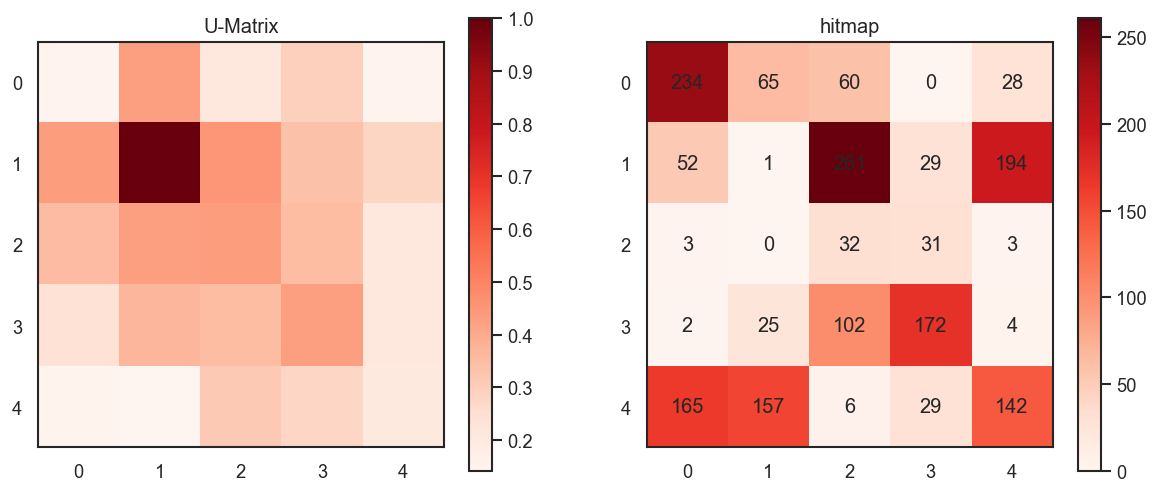

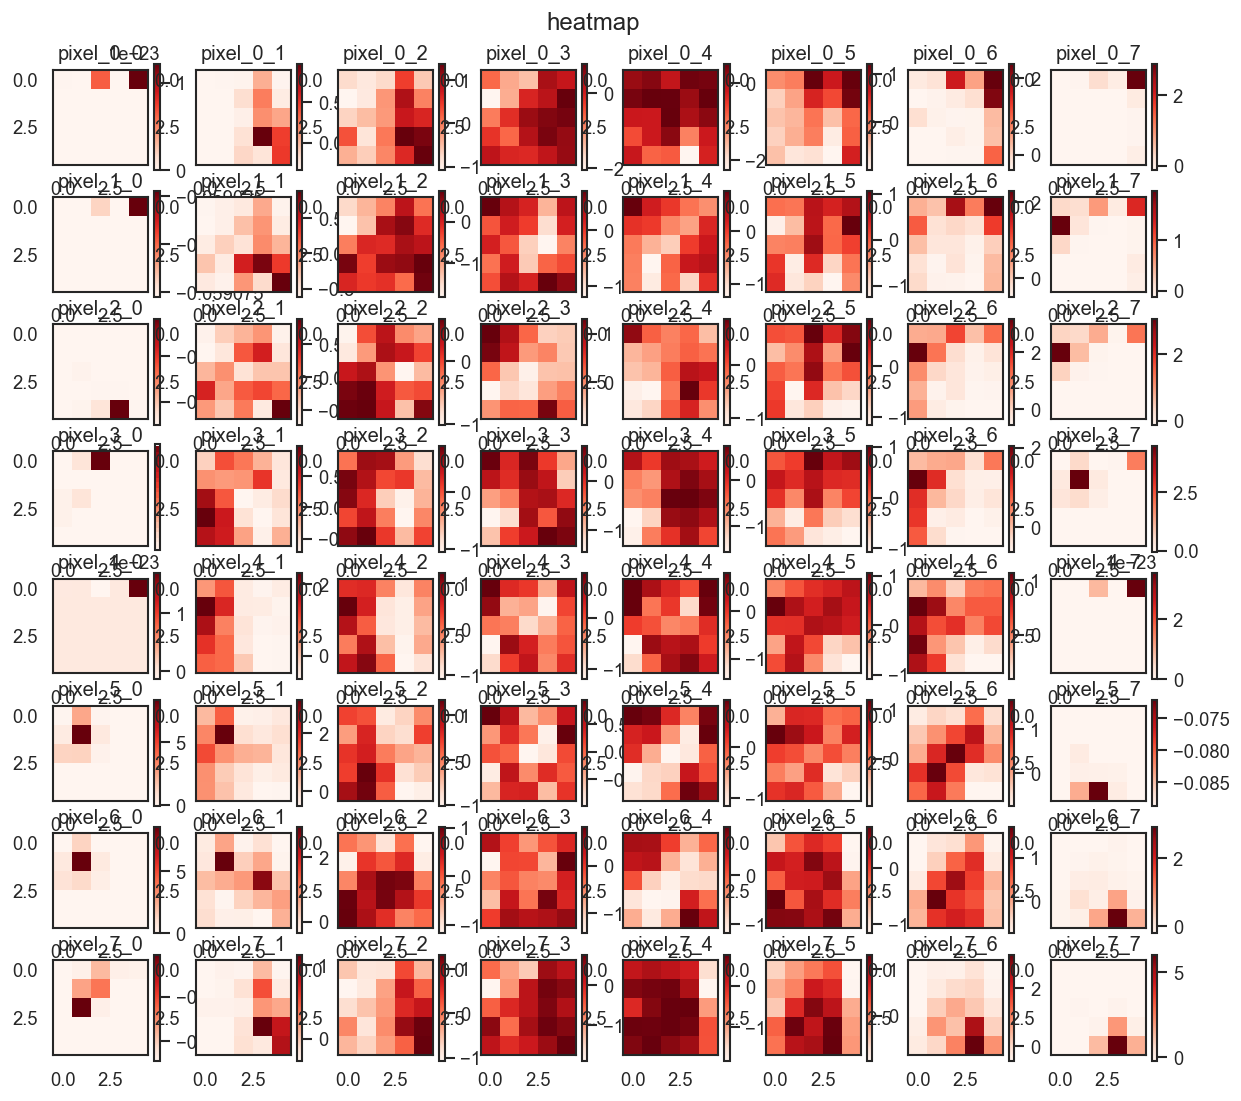

In [10]:
plot_uma_hit_hea(som, digits, (8, 8))

Hexagonal map :

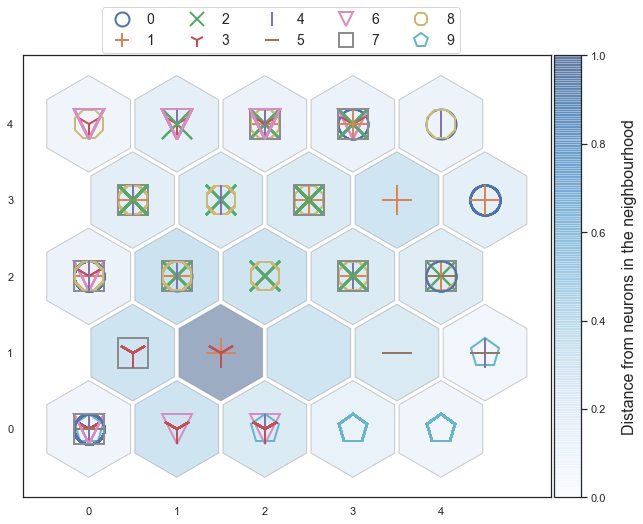

In [13]:
plot_hexa(som, datad, "digits", (10,10), 30)

The hexagonal map reflects the results of the training process. For each class (from 0 to 9) a symbol is associated. Each hexagon represents a neuron. In the graph it is possible to see that a neuron is "empty", with no class associated with it. Also two patterns draw attention, some neurons have an associated class (classes 1, 5, and 9), and the others have several associated classes.

<hr style="height:10px;border-width:0;background-color:blue">

### Grid 10x10

In [14]:
som = MiniSom(10, 10, datad.shape[1],
               sigma=1.5,
               learning_rate=0.7,
               activation_distance="euclidean",
               topology="hexagonal",
               neighborhood_function="gaussian",
               random_seed=123)
som.train(datad, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 4.776125727993084


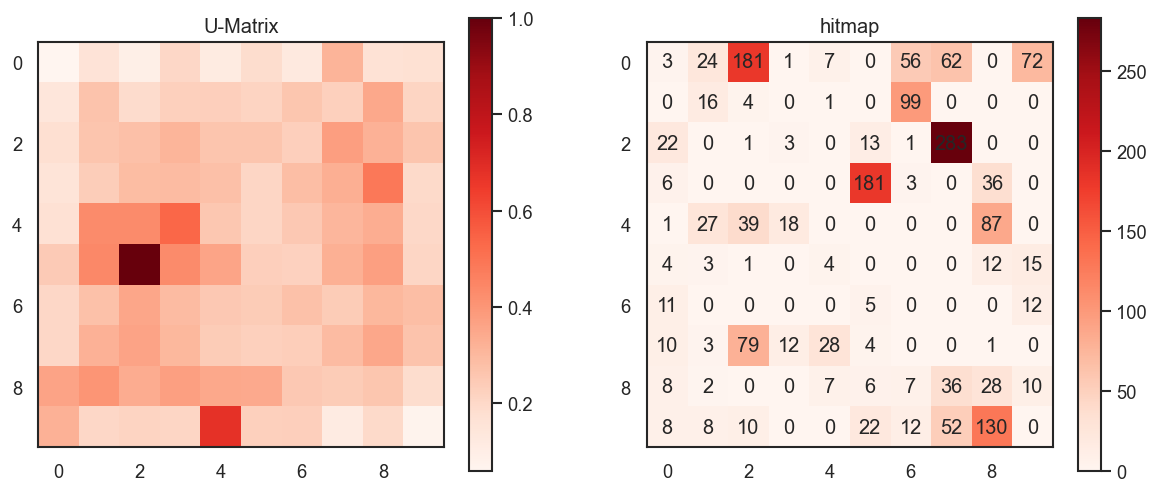

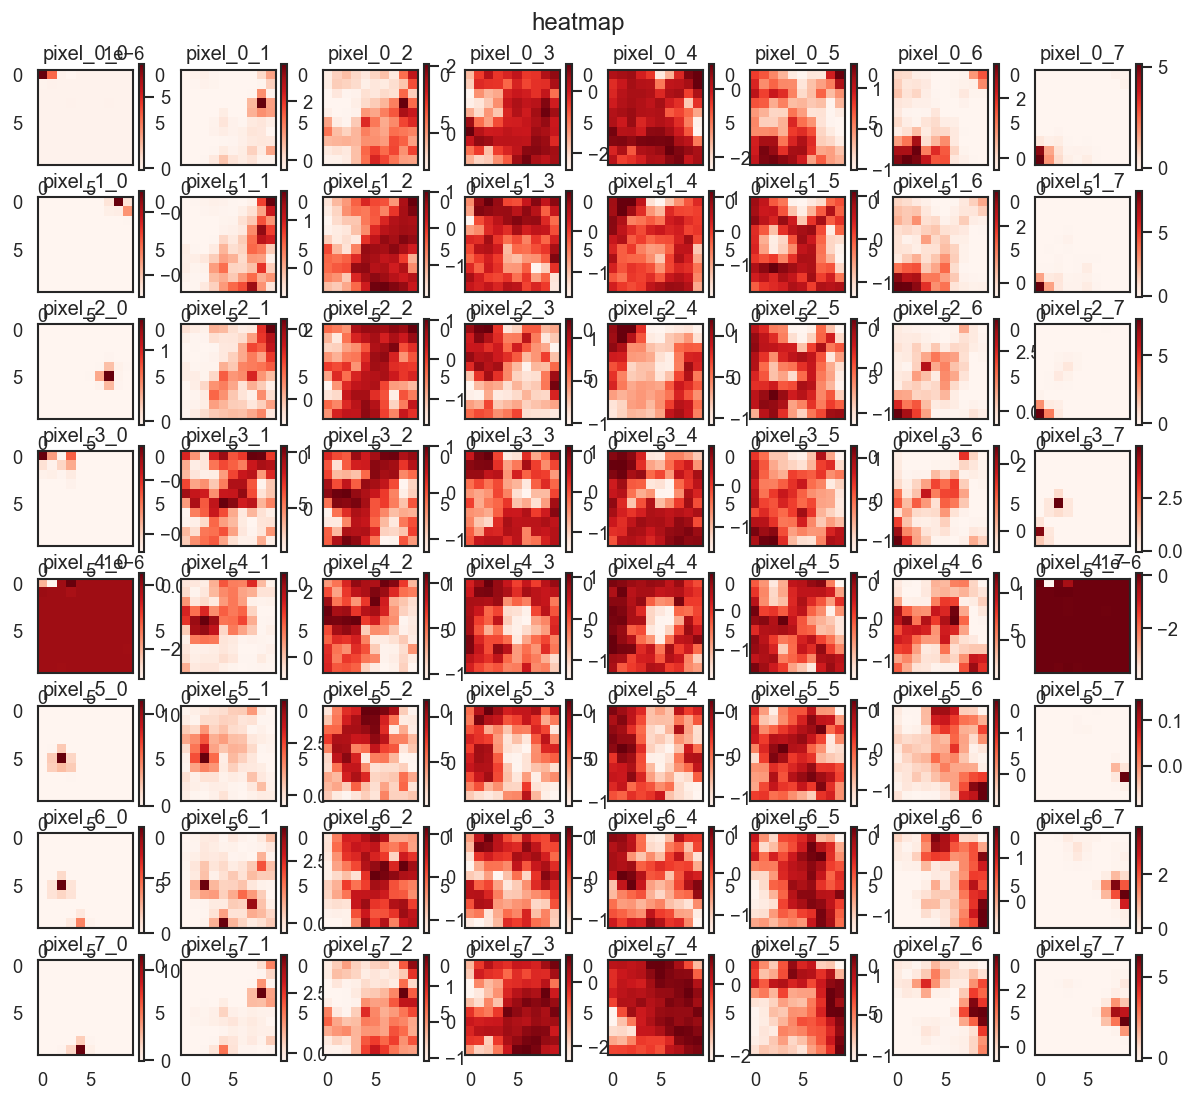

In [15]:
plot_uma_hit_hea(som, digits, (8, 8))

Comparing the above 10x10 grid graphics to the previous 5x5 grid graphics:

- U-Matrix: the patterns appear to be nearx, with a neuron on the left side indicating class 1 in a dark tone.

- hitmap: there is clearly a difference in standards, with the 10x10 grid showing a large amount of neurons with no association with the input data. There is a similarity that it is a neuron with a large amount of associated inputs, which for 10x10 is 283 points, and for 5x5 is 261.

- heatmap: are similar for the two grids, showing a concentration of weights in the central part, where the digits are drawn.

Hexagonal map :

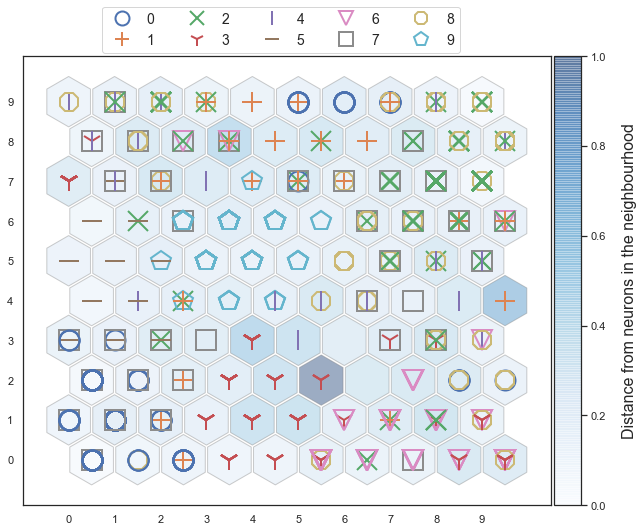

In [16]:
plot_hexa(som, datad, "digits", (10,10), 20)

Comparing this hexagon map with the previous one, one more neuron without association with the input data is noticed, and a better distribution of patterns, for example class 3 appears well defined at the bottom.

<hr style="height:10px;border-width:0;background-color:blue">

### Grid 15x15

In [17]:
som = MiniSom(15, 15, datad.shape[1],
               sigma=1.5,
               learning_rate=0.7,
               activation_distance="euclidean",
               topology="hexagonal",
               neighborhood_function="gaussian",
               random_seed=123)
som.train(datad, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 4.347497743913177


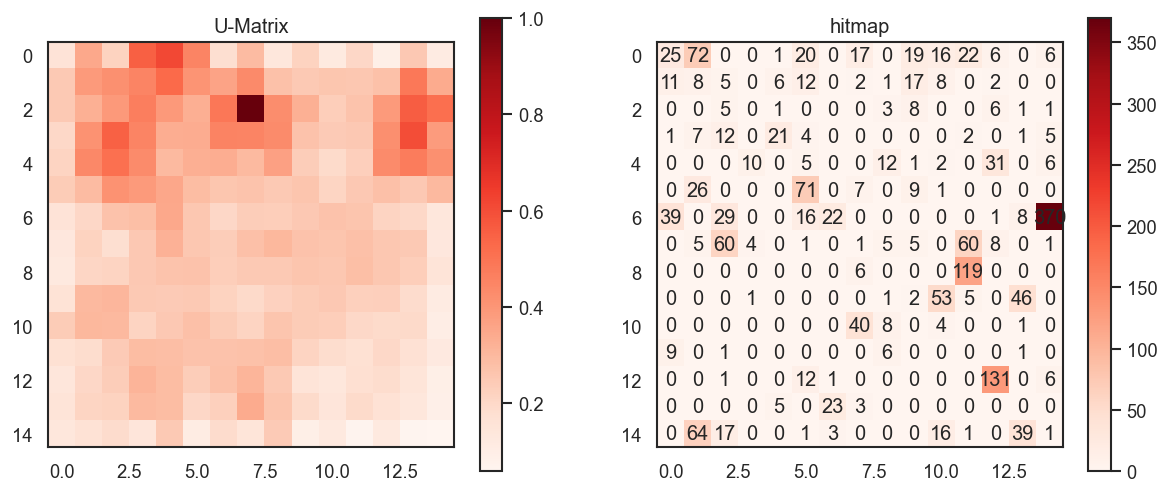

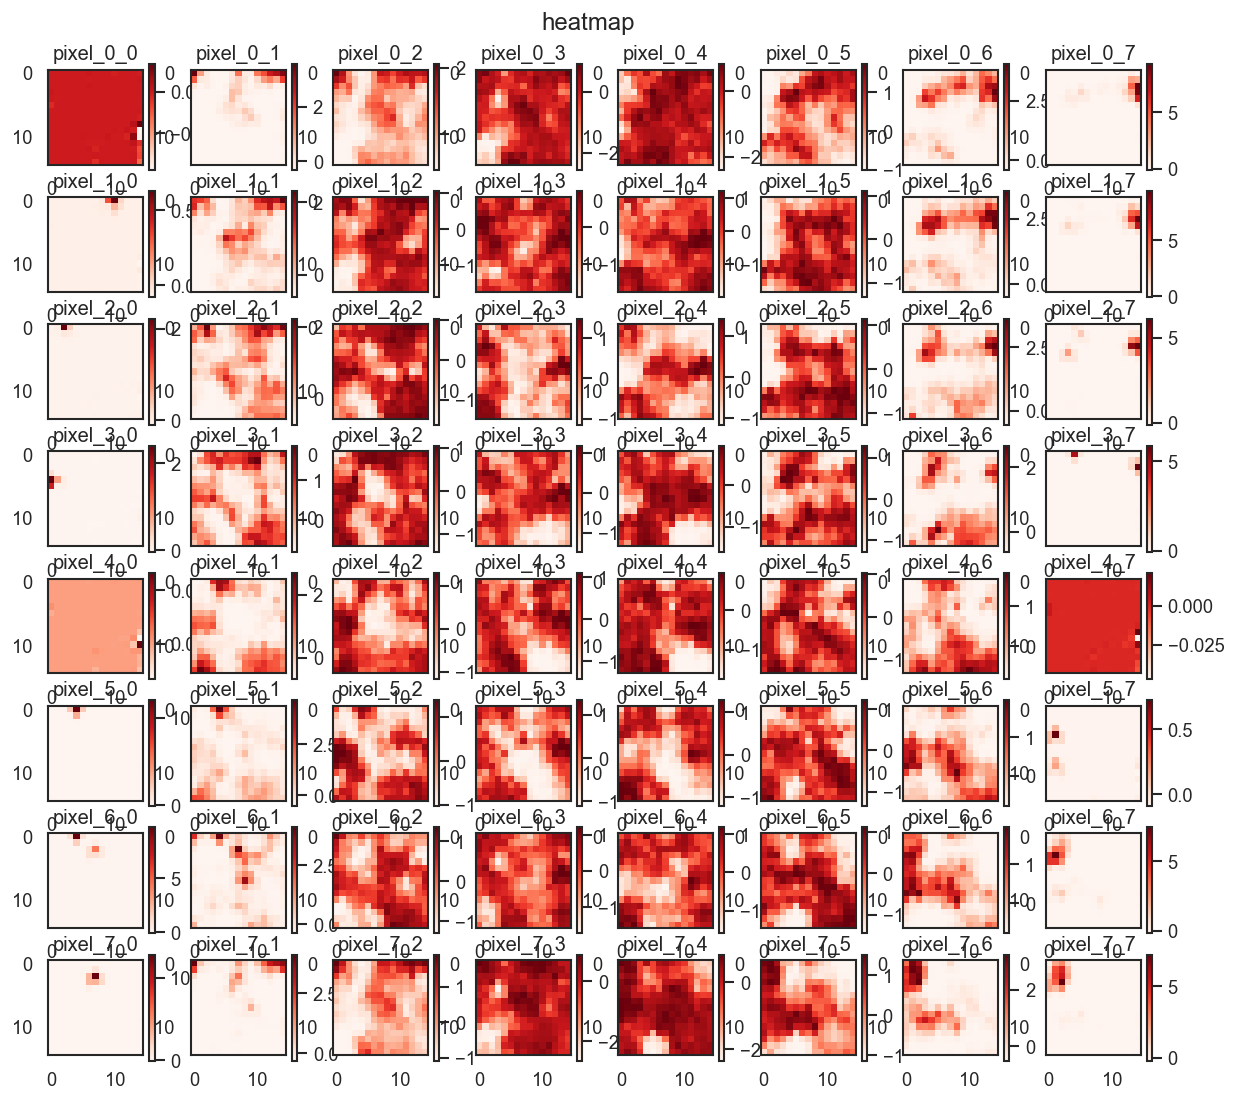

In [18]:
plot_uma_hit_hea(som, digits, (8, 8))

For this grid size (15x15) the behavior was similar to the previous one (10x10), further increasing the number of neurons without association with the input data, visualized in the hitmap. The other previous comments are valid in this case as well.

Hexagonal map:

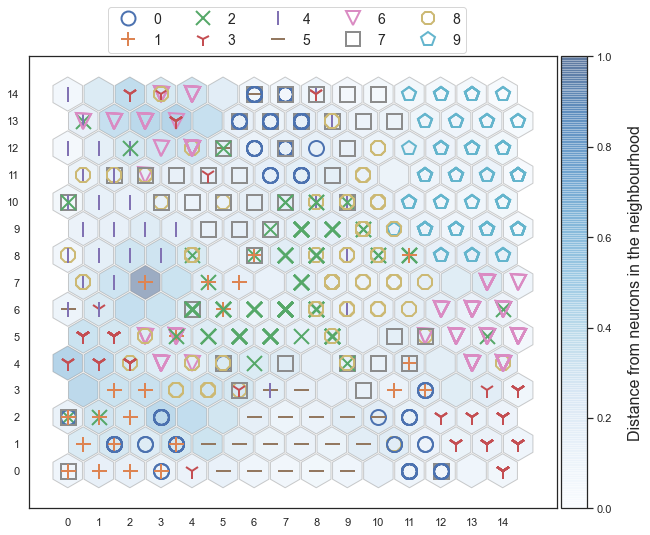

In [ ]:
plot_hexa(som, datad, "digits", (10,10), 15)

Comparing with the previous hexagonal map, it is now possible to identify more patterns, for example class 9 in the upper right corner, and class 5 in the bottom part. However, the number of neurons without association with the input data increased.

<hr style="height:10px;border-width:0;background-color:green">

## Sigma variation

For sigma variation, the other parameters were fixed:
     - grid 10x10
     - learning rate 0.7
     - 1000 training iterations

In the following sections some comparisons are made with the previous item referring to the 10x10 grid and sigma 1.5.

### Sigma 0.5

In [50]:
sds5 = MiniSom(10, 10, datad.shape[1],
              sigma=0.5,
              learning_rate=0.7,
              activation_distance="euclidean",
              topology="hexagonal",
              neighborhood_function="gaussian",
              random_seed=123)
sds5.train(datad, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 4.915157450079205


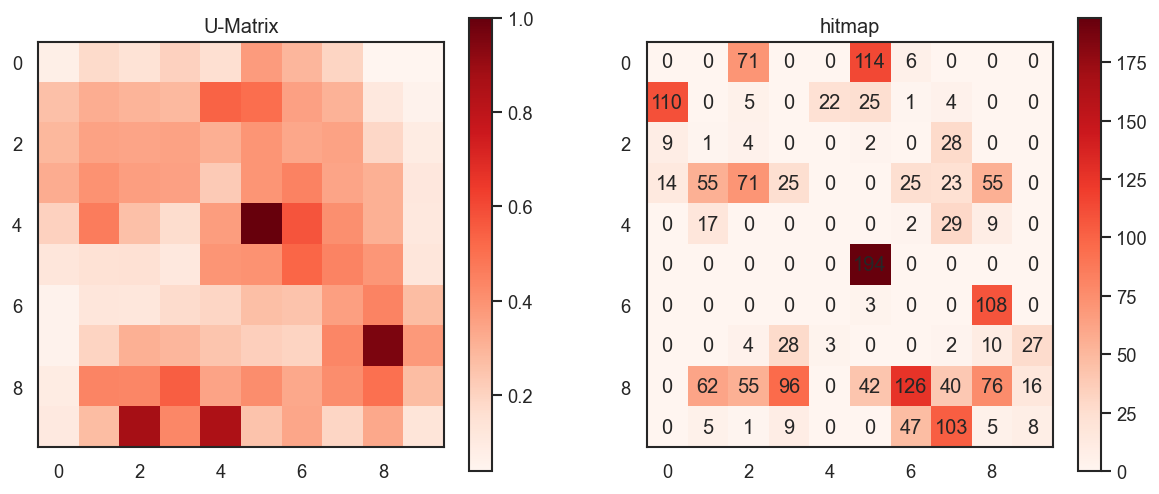

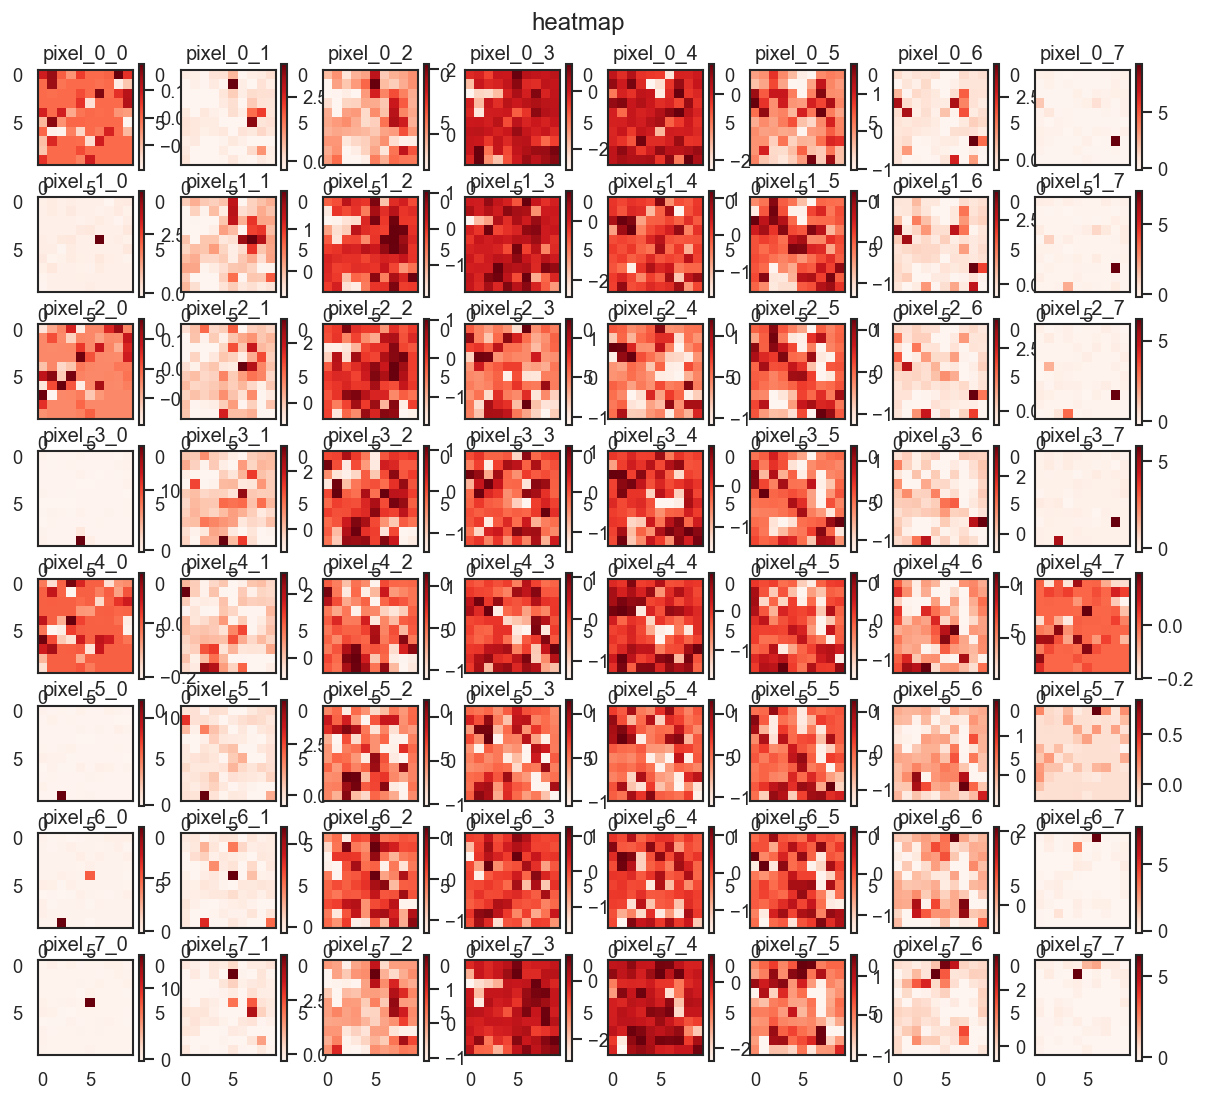

In [51]:
plot_uma_hit_hea(sds5, digits, (8, 8))

Simply put, sigma denotes the network radius used to find the neighborhood of the winning neuron.

The following are some comments regarding the charts above:

- U-Matrix : comparing the graph above (sigma=0.5) with the previous one (sigma=1.5), one can see more neurons with dark colors, indicating a slightly better distribution of classes (association of input data) between neurons .

- hitmap : comparing the graphs, there is still a neuron with a large amount of associated points, but the number of associations is smaller. There are also more neurons with more associations. However, there are still many neurons without association.

- heatmap : there is a greater distribution of patterns, especially on the edges of the chart/map shown above.

<hr style="height:10px;border-width:0;background-color:blue">

### Sigma 3

In [56]:
sds3 = MiniSom(10, 10, datad.shape[1],
              sigma=3,
              learning_rate=0.7,
              activation_distance="euclidean",
              topology="hexagonal",
              neighborhood_function="gaussian",
              random_seed=123)
sds3.train(datad, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 5.446856992285048


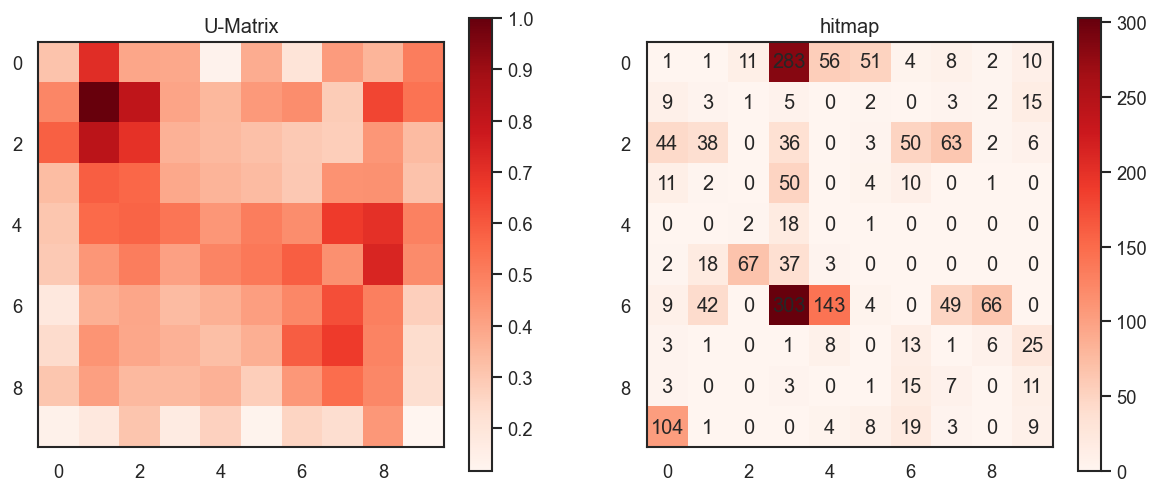

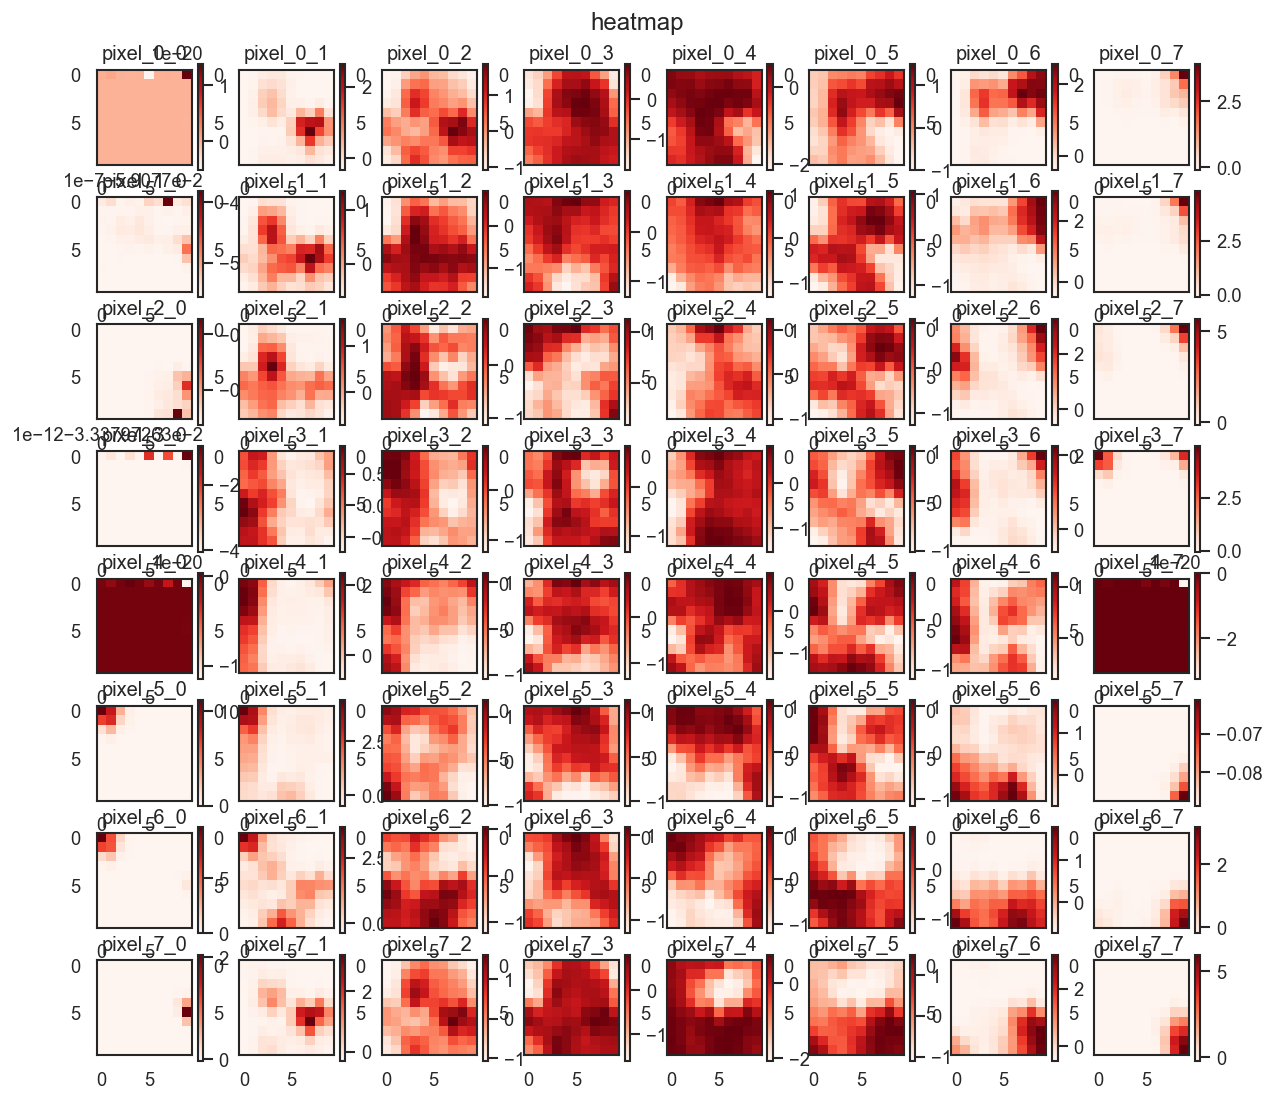

In [57]:
plot_uma_hit_hea(sds3, digits, (8, 8))

By increasing the sigma, the number of neurons with a large number of associations increases a little. The amount of neurons without association remains high.

<hr style="height:10px;border-width:0;background-color:blue">

### Sigma 9

In [59]:
sds9 = MiniSom(10, 10, datad.shape[1],
              sigma=9,
              learning_rate=0.7,
              activation_distance="euclidean",
              topology="hexagonal",
              neighborhood_function="gaussian",
              random_seed=123)
sds9.train(datad, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 6.941713283316392


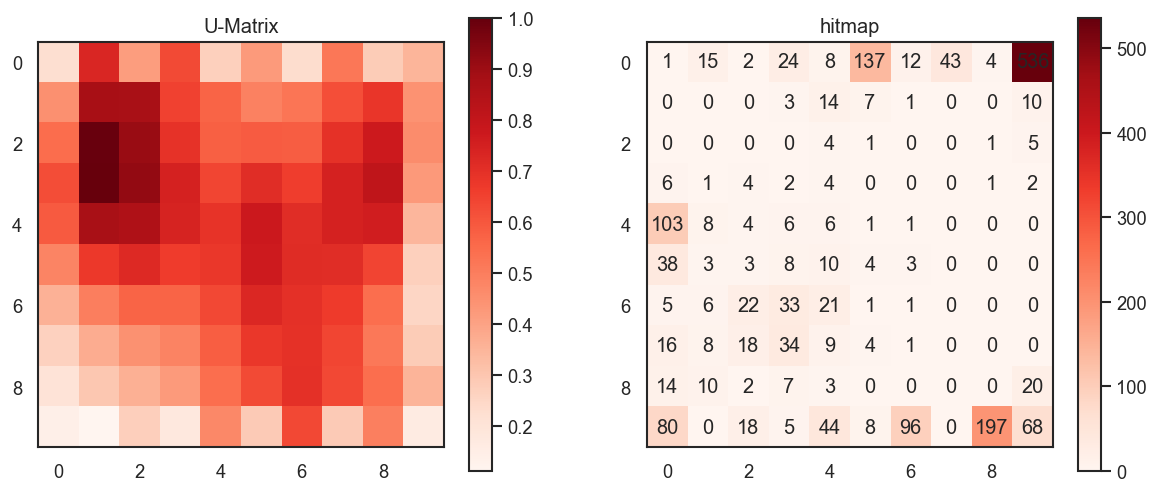

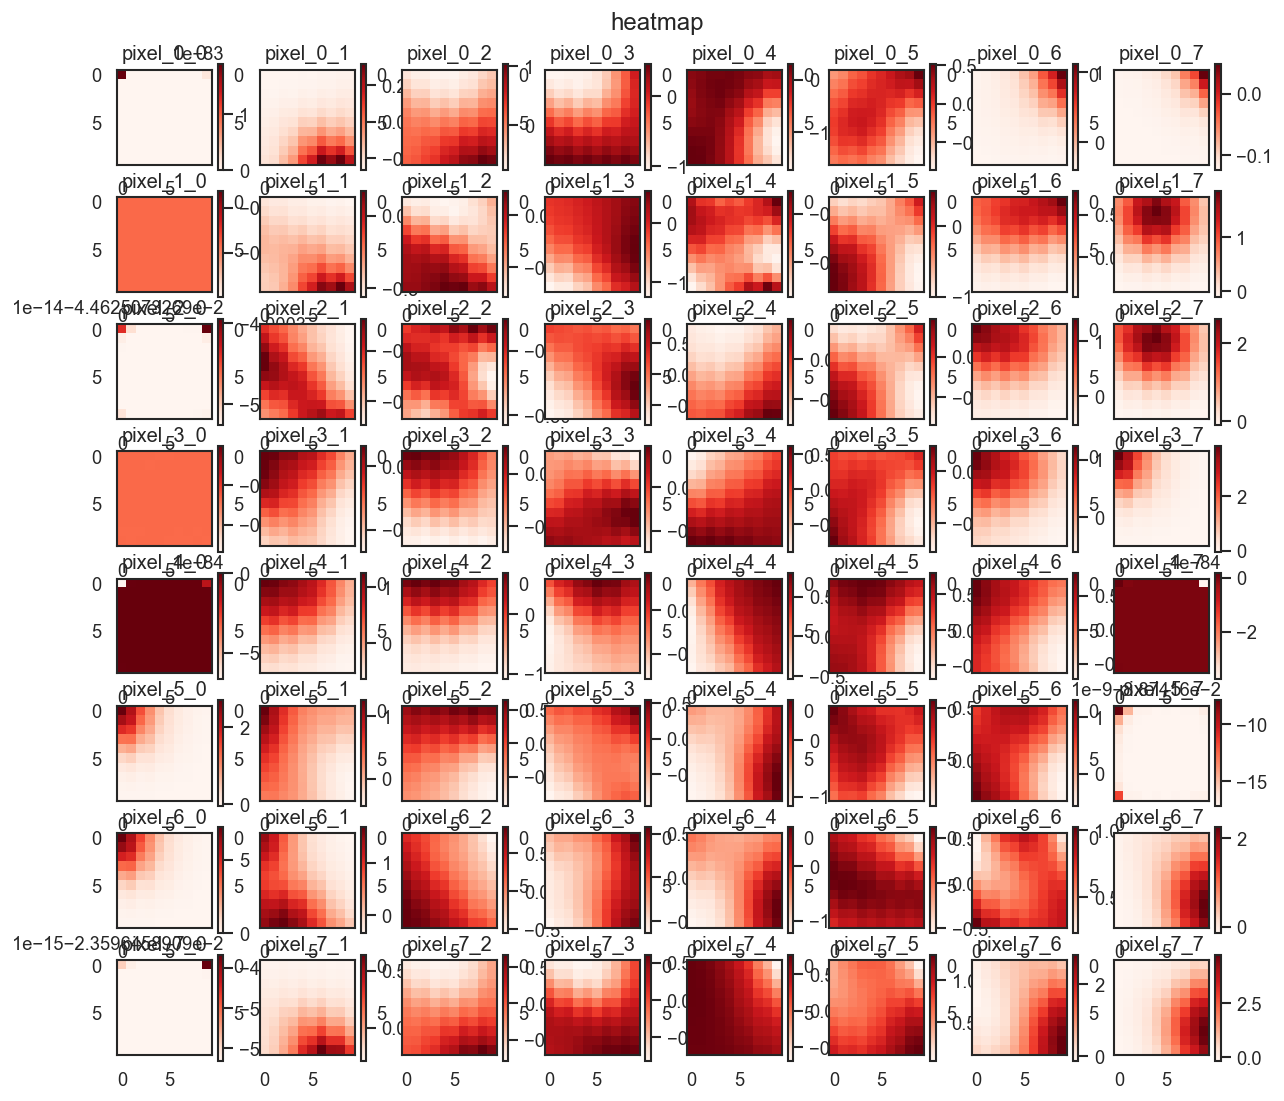

In [60]:
plot_uma_hit_hea(sds9, digits, (8, 8))

Increasing the sigma further formed a pattern, with the edge neurons containing more associations. However, in general, there were no major changes in standards.

<hr style="height:10px;border-width:0;background-color:green">

## Learning rate (LR)

### LR = .5

In [28]:
sda5 = MiniSom(10, 10, datad.shape[1],
              sigma=1.5,
              learning_rate=0.5,
              activation_distance="euclidean",
              topology="hexagonal",
              neighborhood_function="gaussian",
              random_seed=123)
sda5.train(datad, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 4.826704039196338


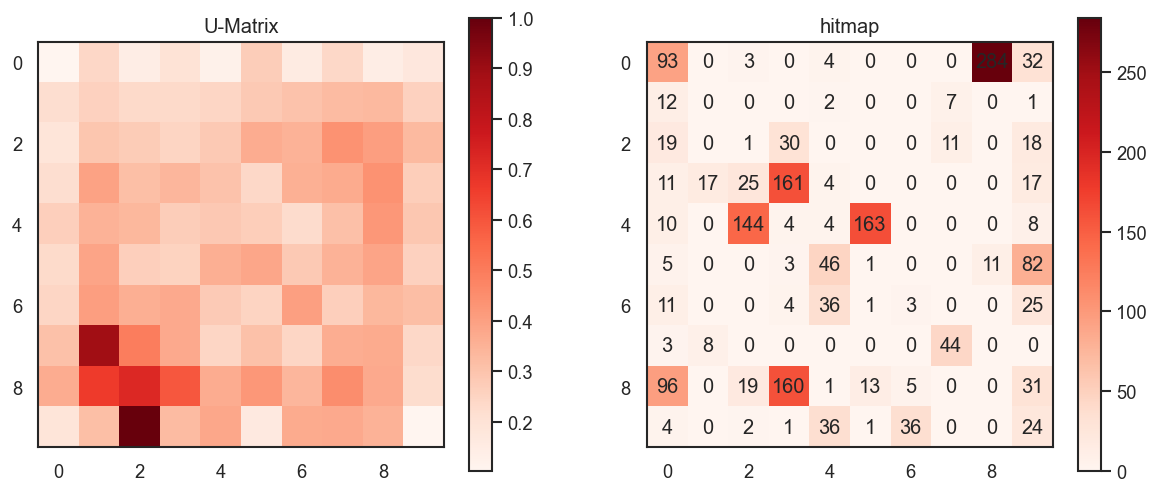

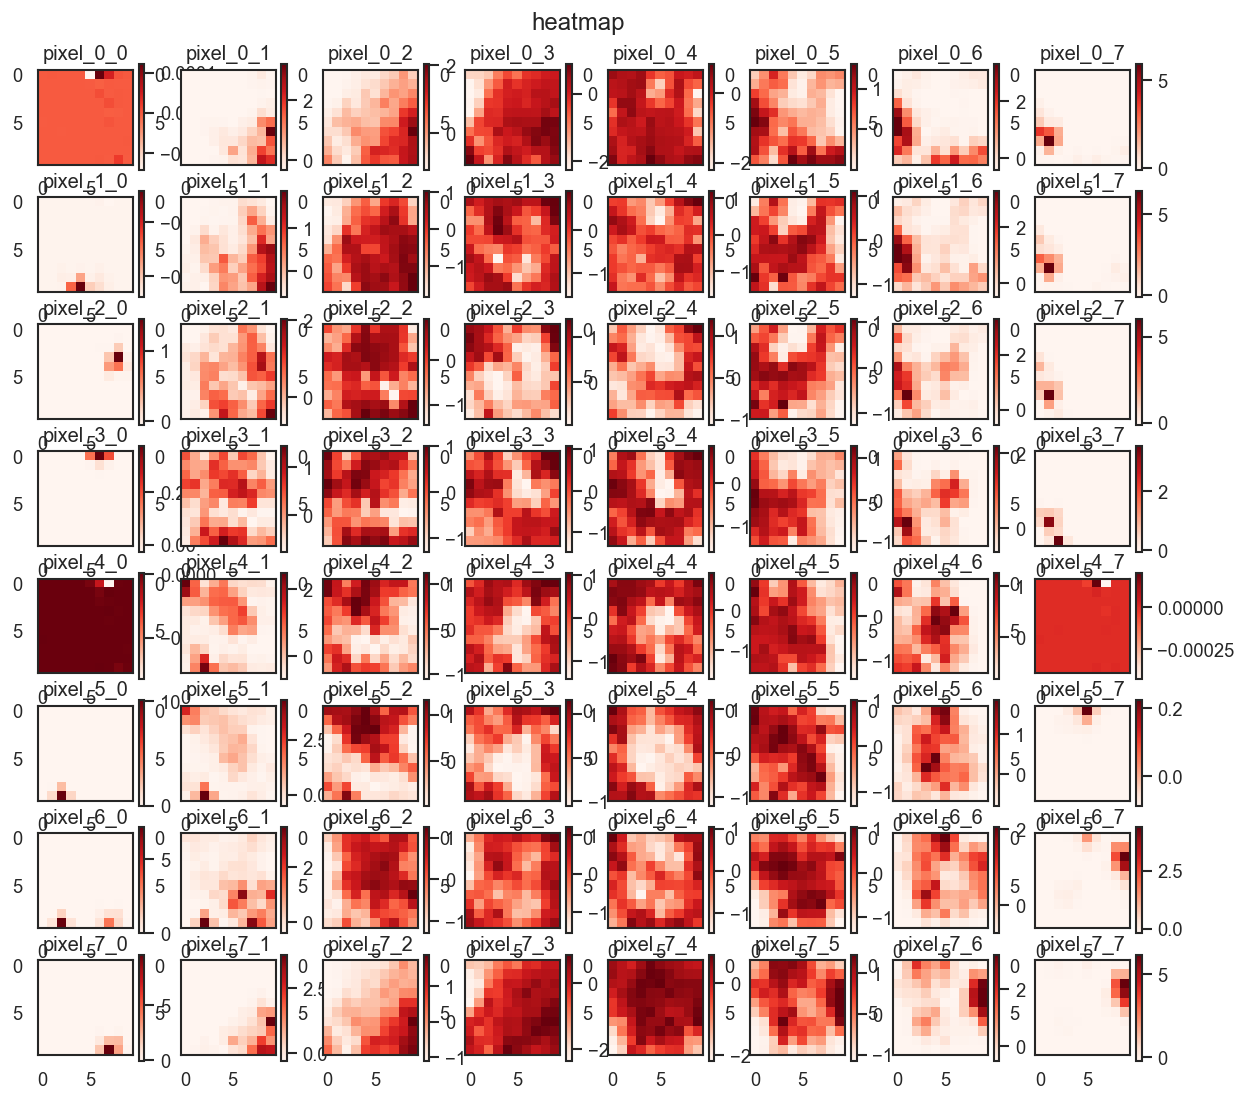

In [ ]:
plot_uma_hit_hea(sda5, digits, (8, 8))

By reducing the learning rate, the tendency of clustering of neurons with close classes increased, and increased the scattering of neurons with more associations.

<hr style="height:10px;border-width:0;background-color:blue">

### LR = 1

In [63]:
sda1 = MiniSom(10, 10, datad.shape[1],
              sigma=1.5,
              learning_rate=1,
              activation_distance="euclidean",
              topology="hexagonal",
              neighborhood_function="gaussian",
              random_seed=123)
sda1.train(datad, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 4.928331732273808


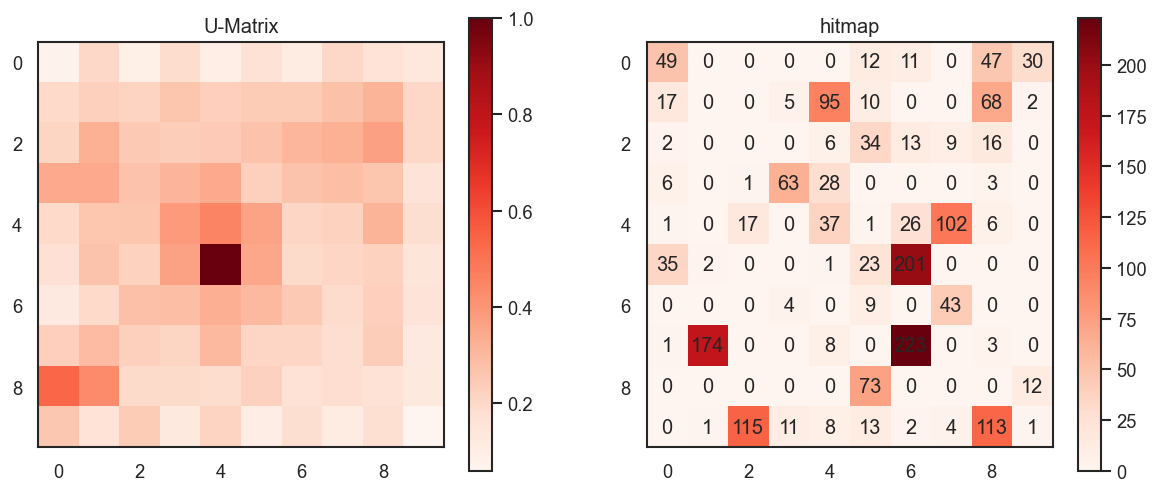

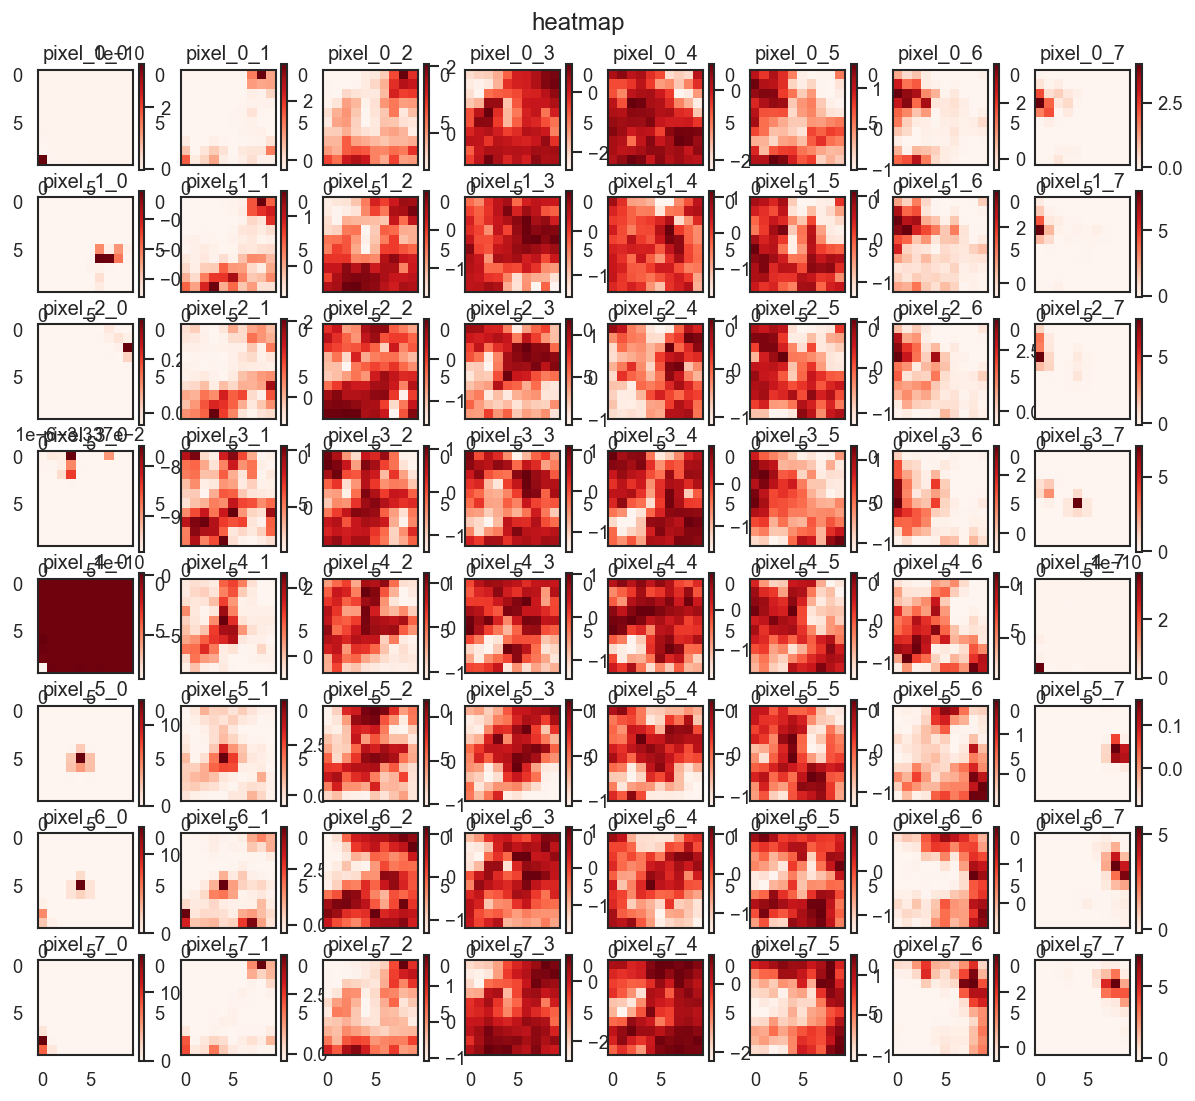

In [64]:
plot_uma_hit_hea(sda1, digits, (8, 8))

By increasing the learning rate, the patterns become more defined, and the number of unassociated neurons decreases.

<hr style="height:10px;border-width:0;background-color:blue">

### LR = 3

In [65]:
sda3 = MiniSom(10, 10, datad.shape[1],
              sigma=1.5,
              learning_rate=3,
              activation_distance="euclidean",
              topology="hexagonal",
              neighborhood_function="gaussian",
              random_seed=123)
sda3.train(datad, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 5.179345441802047


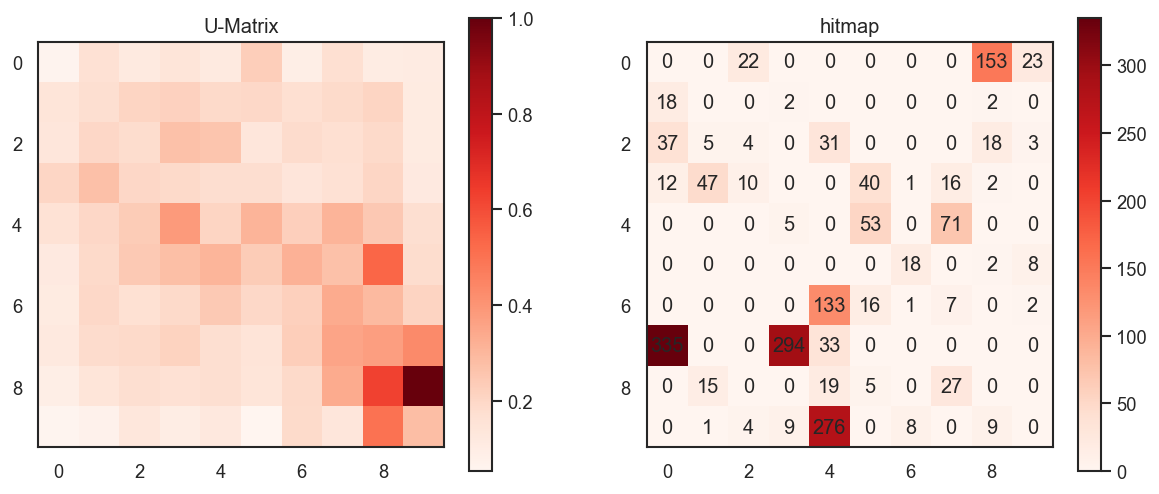

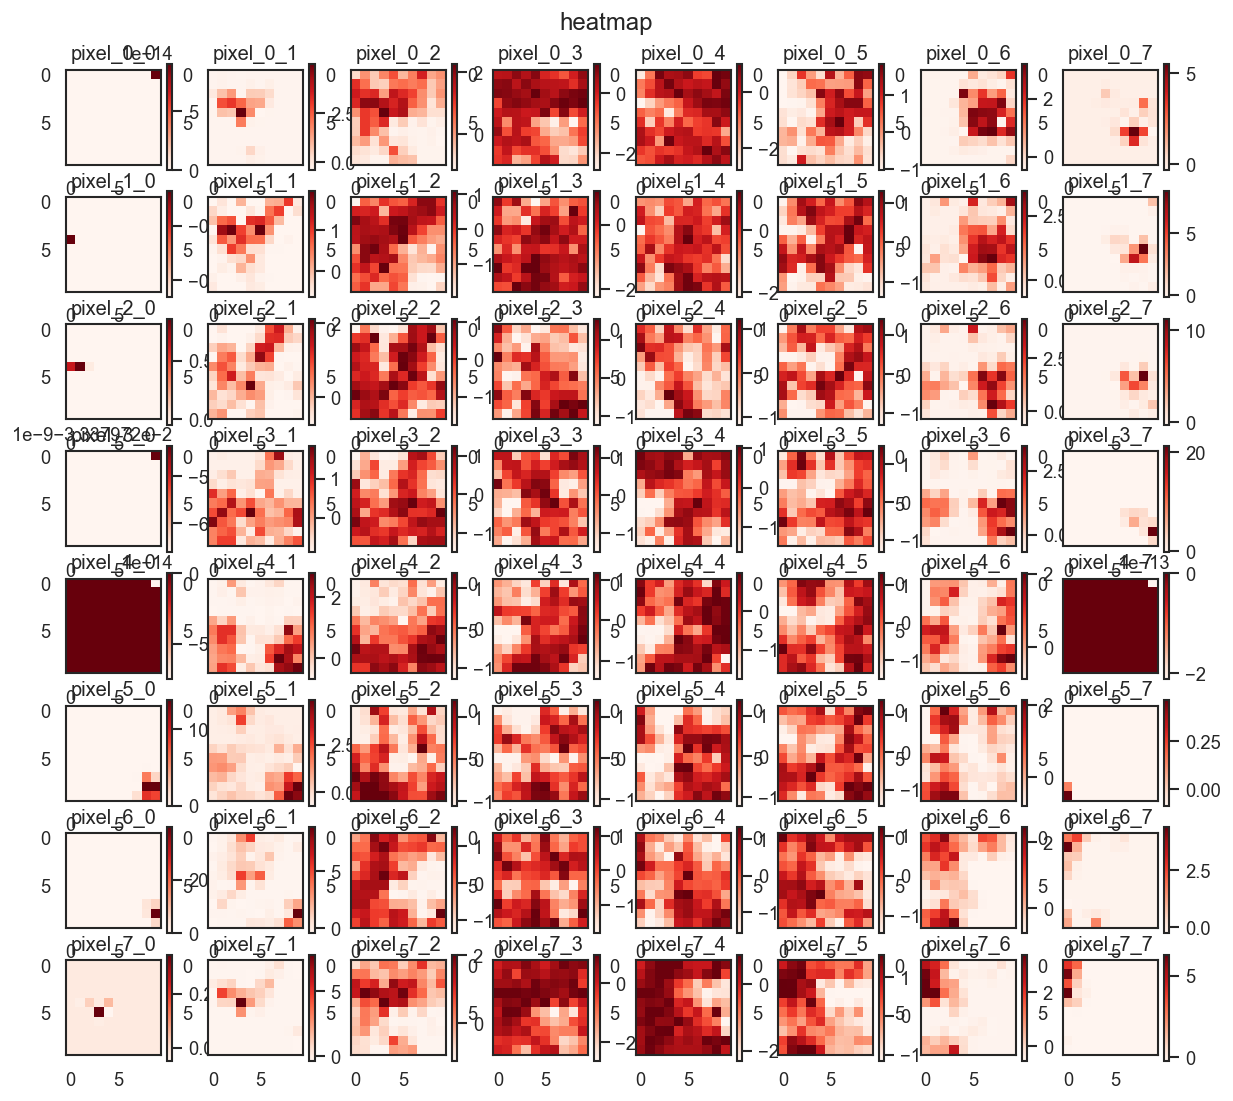

In [66]:
plot_uma_hit_hea(sda3, digits, (8, 8))

Increasing the learning rate further worsened the homogeneity of the patterns.

<hr style="height:10px;border-width:0;background-color:green">

## Training iterations

### Training 100

In [34]:
sdt1 = MiniSom(10, 10, datad.shape[1],
              sigma=1.5,
              learning_rate=.7,
              activation_distance="euclidean",
              topology="hexagonal",
              neighborhood_function="gaussian",
              random_seed=123)
sdt1.train(datad, 100, verbose=True)

 [ 100 / 100 ] 100% - 0:00:00 left 
 quantization error: 5.644297083786318


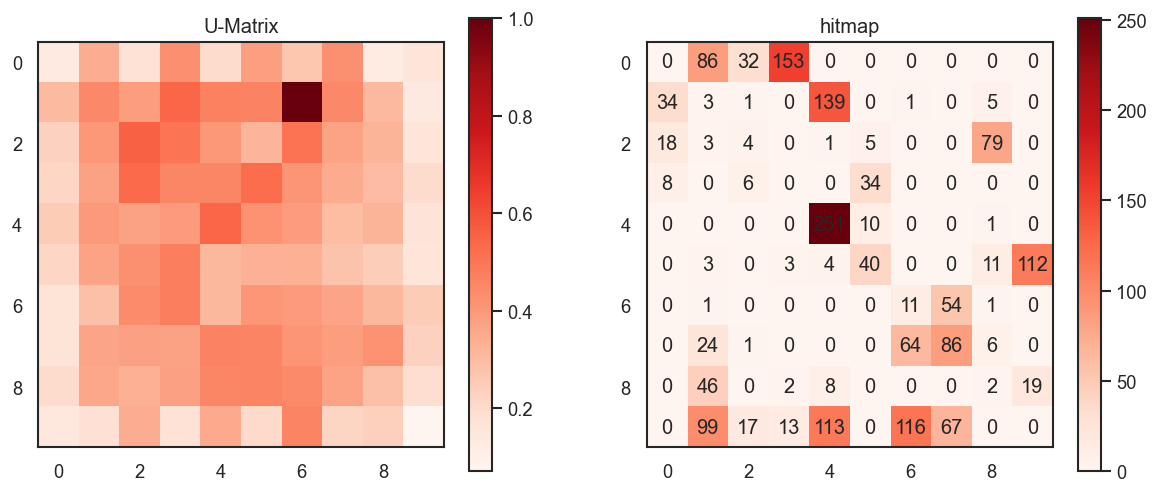

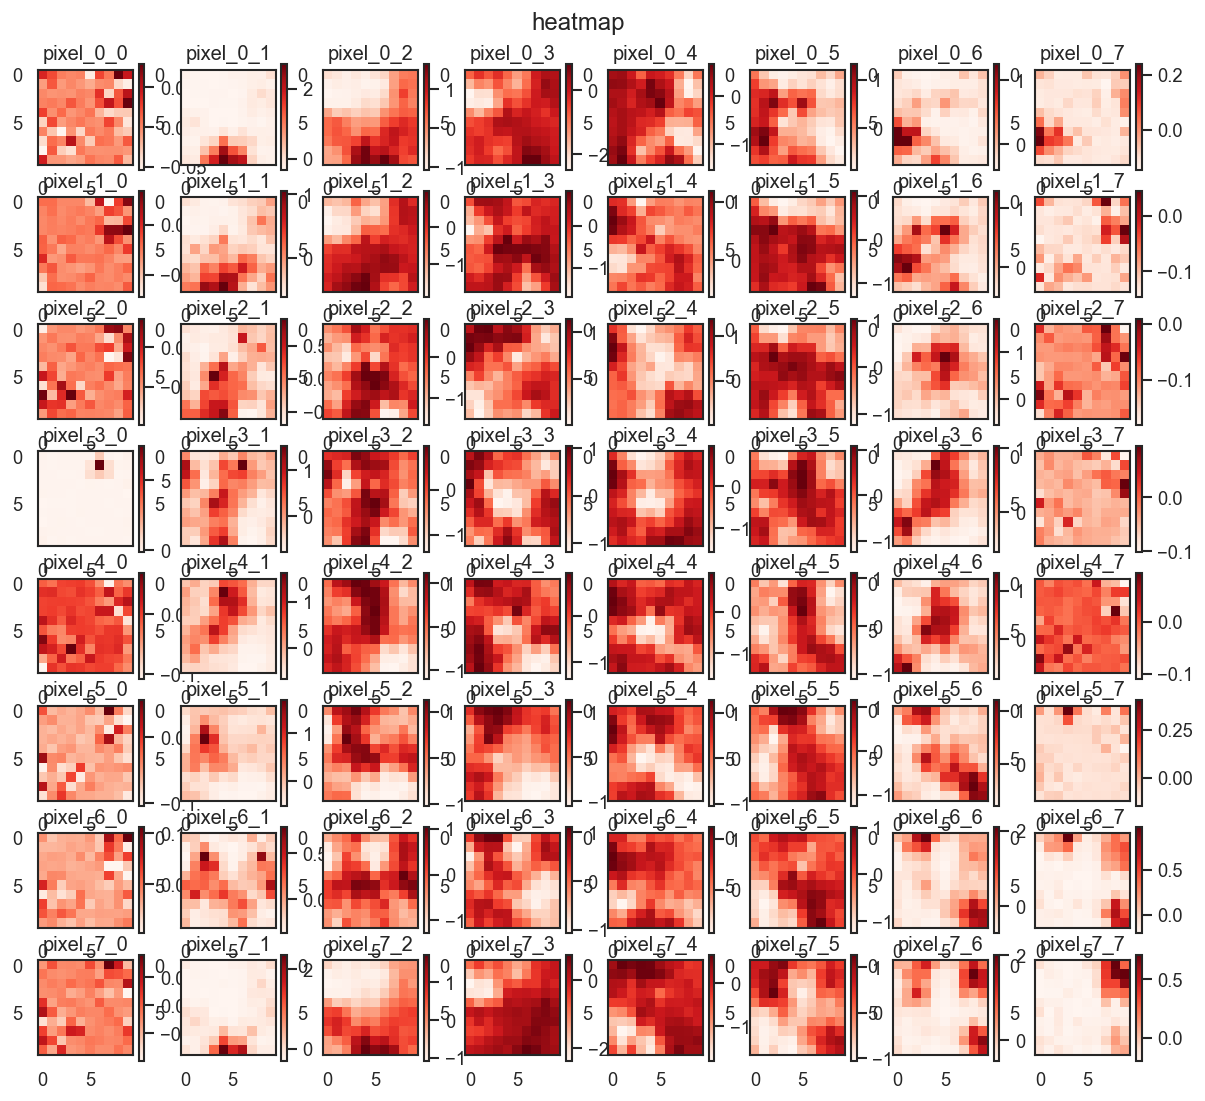

In [35]:
plot_uma_hit_hea(sdt1, digits, (8, 8))

Reducing the number of iterations slightly improves the homogeneity of the patterns, but the heatmap is noisy on the sides of the map.

<hr style="height:10px;border-width:0;background-color:blue">

### Training 500

In [36]:
sdt5 = MiniSom(10, 10, datad.shape[1],
              sigma=1.5,
              learning_rate=.7,
              activation_distance="euclidean",
              topology="hexagonal",
              neighborhood_function="gaussian",
              random_seed=123)
sdt5.train(datad, 500, verbose=True)

 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 4.964716072112193


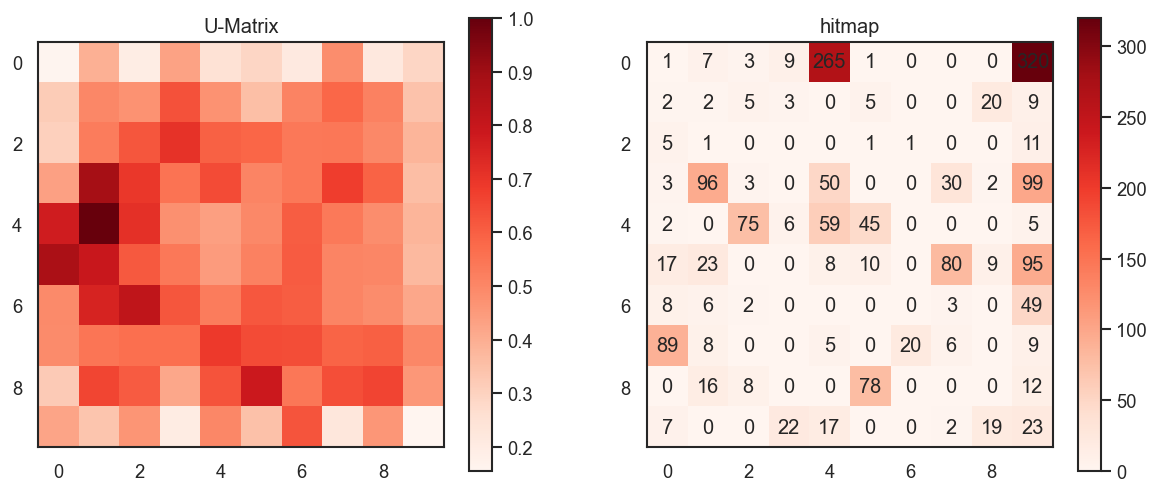

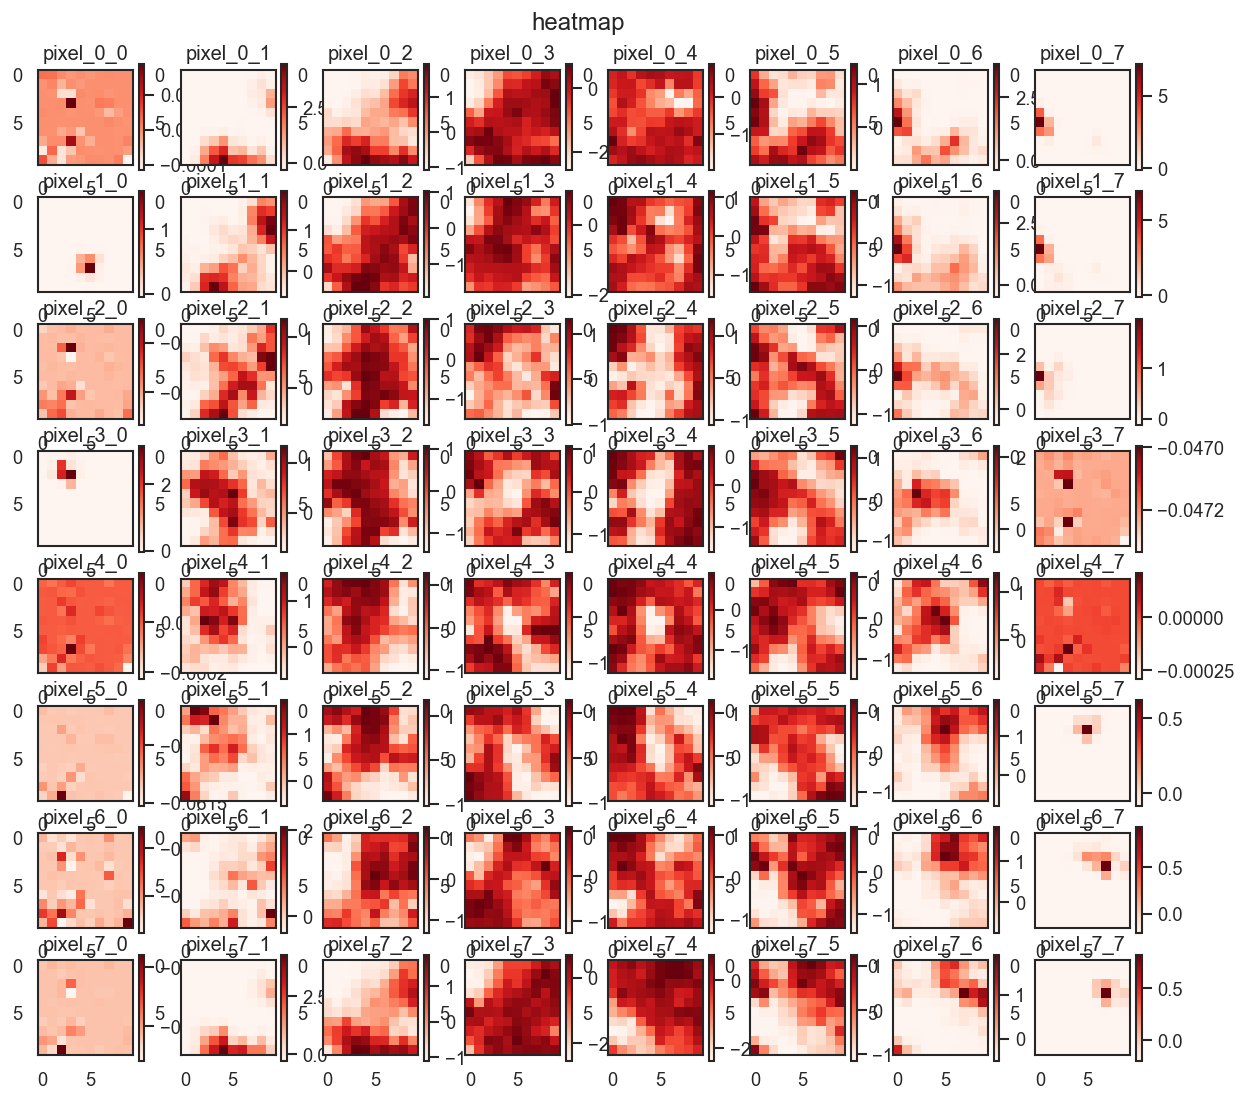

In [37]:
plot_uma_hit_hea(sdt5, digits, (8, 8))

Increasing the number of iterations increases the concentration of associations to a few neurons, and reduces it to the others.

<hr style="height:10px;border-width:0;background-color:blue">

### Training 2000

In [38]:
sdt2 = MiniSom(10, 10, datad.shape[1],
              sigma=1.5,
              learning_rate=.7,
              activation_distance="euclidean",
              topology="hexagonal",
              neighborhood_function="gaussian",
              random_seed=123)
sdt2.train(datad, 2000, verbose=True)

 [ 2000 / 2000 ] 100% - 0:00:00 left 
 quantization error: 4.73310046673206


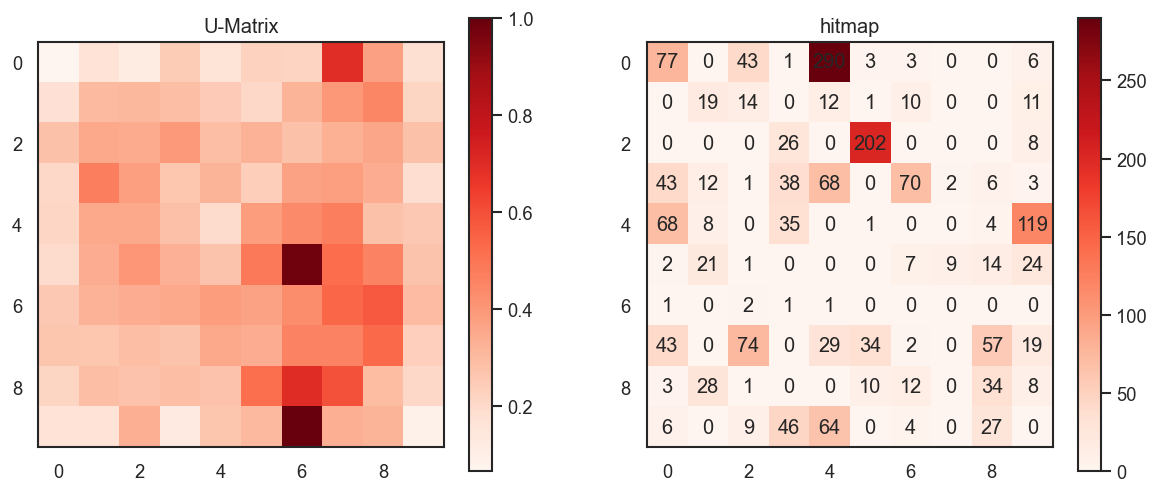

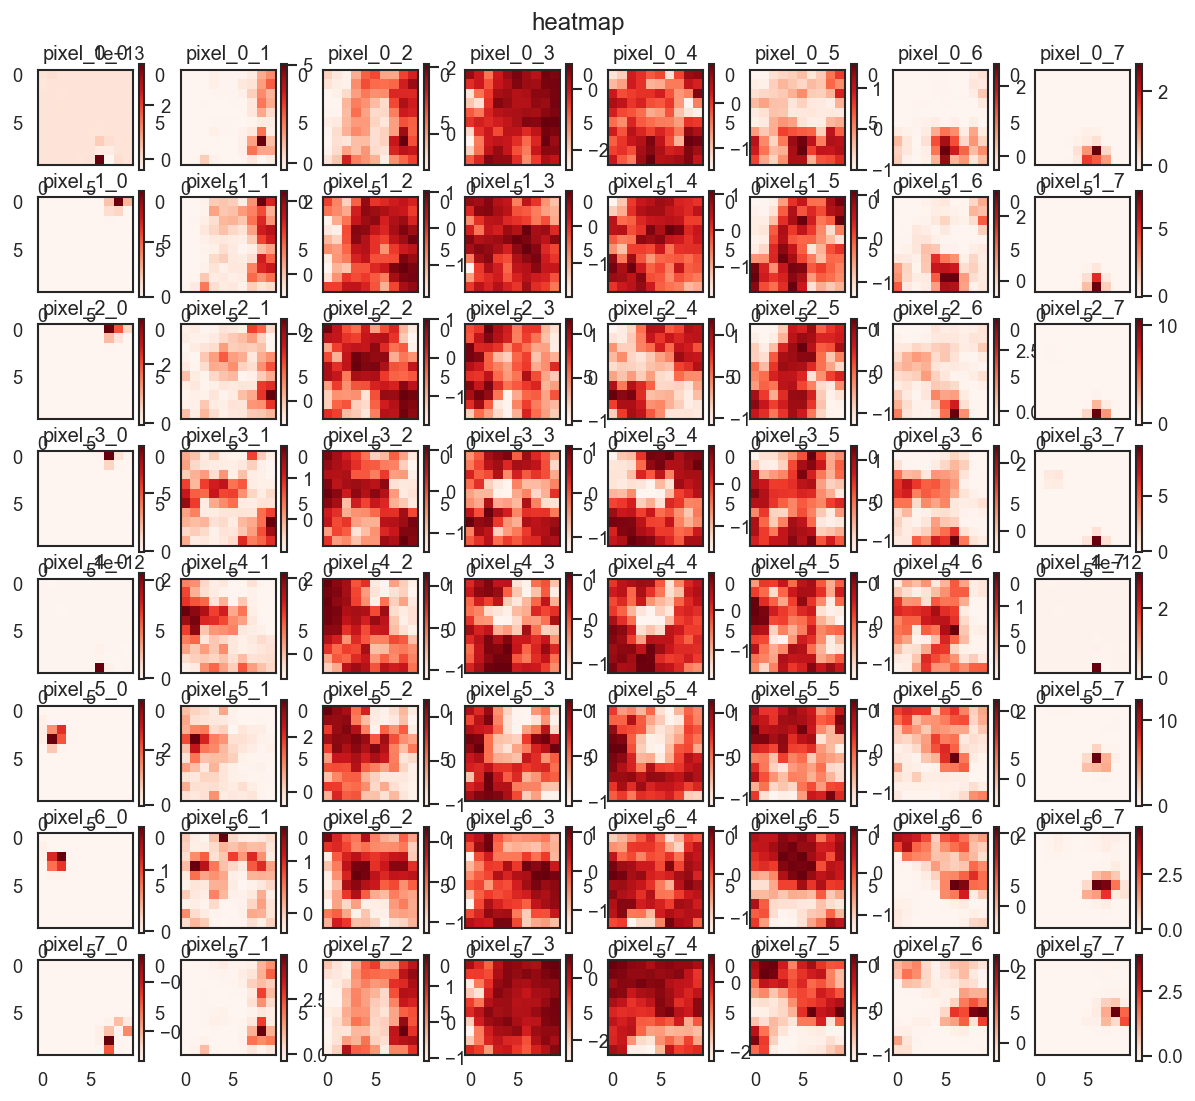

In [39]:
plot_uma_hit_hea(sdt2, digits, (8, 8))

Increasing the number of iterations further, it is already possible to distinguish a pattern with three sets of neurons.

<hr style="height:10px;border-width:0;background-color:red">

# SECOND *DATASET* - WINE

This section shows the same variations as the previous section, now using the Wine dataset:

- grid
- sigma
- learning rate
- Training iterations

In [40]:
wine = load_wine()

In [41]:
dataw = wine.data

## Grid variation

### Grid 5x5

In [42]:
sw5 = MiniSom(5, 5, dataw.shape[1], random_seed = 123)
sw5.random_weights_init(dataw)
train_error = manual_random_training(sw5, dataw, 1000)
print_error(sw5, dataw)

quantization_error: 17.835275645064964
topographic_error: 0.2640449438202247


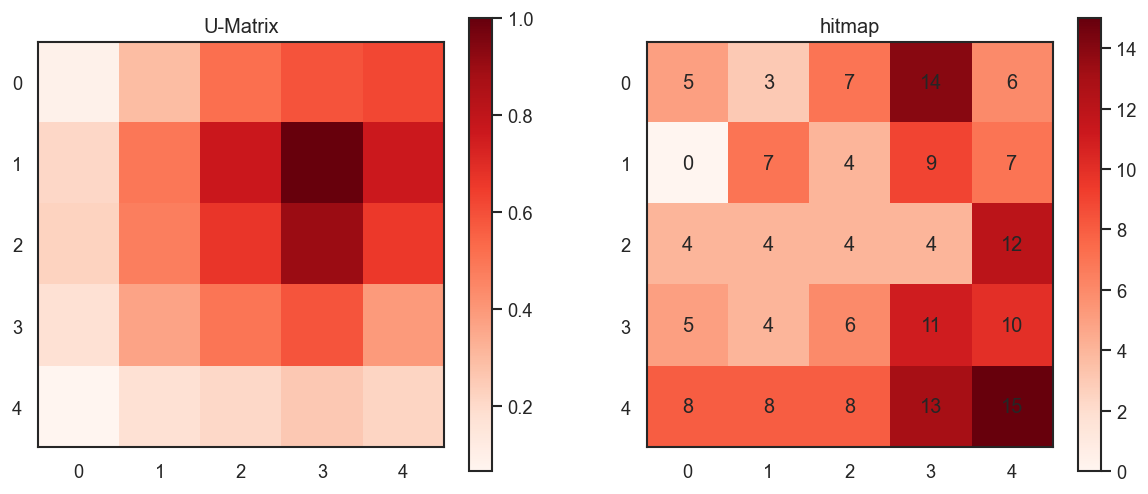

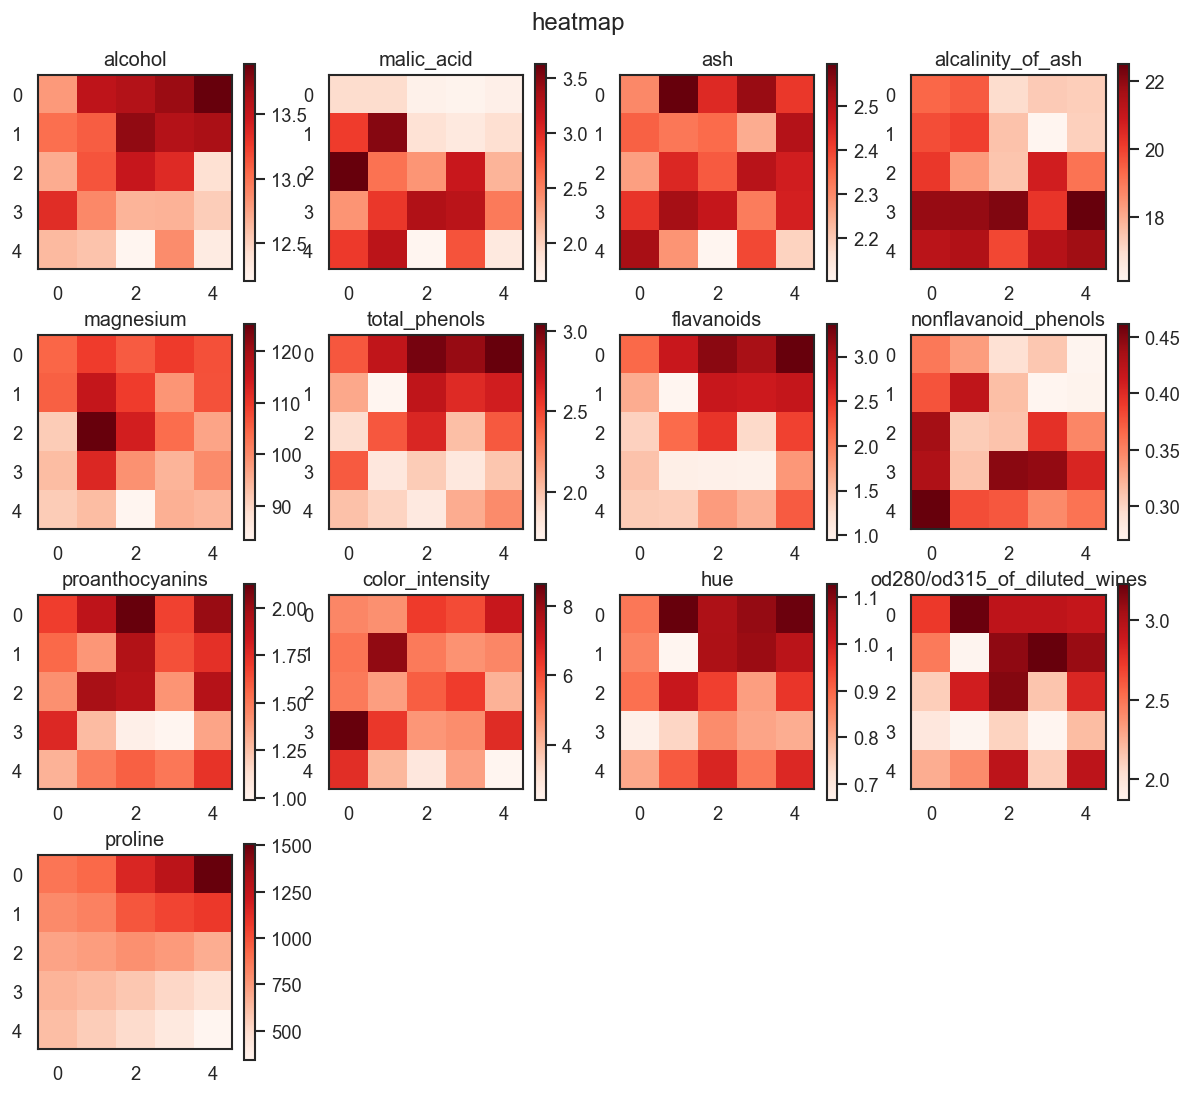

In [43]:
plot_uma_hit_hea(sw5, wine, (4, 4))

With a 5x5 grid it is possible to distinguish a class of neuron patterns.

<hr style="height:10px;border-width:0;background-color:blue">

### Grid 10x10

In [44]:
sw10 = MiniSom(10, 10, dataw.shape[1], random_seed = 123)
sw10.random_weights_init(dataw)
train_error = manual_random_training(sw10, dataw, 1000)
print_error(sw10, dataw)

/opt/anaconda3/envs/tf/lib/python3.9/site-packages/minisom.py:513: RuntimeWarning: invalid value encountered in sqrt


quantization_error: 10.13125464237186
topographic_error: 0.5561797752808989


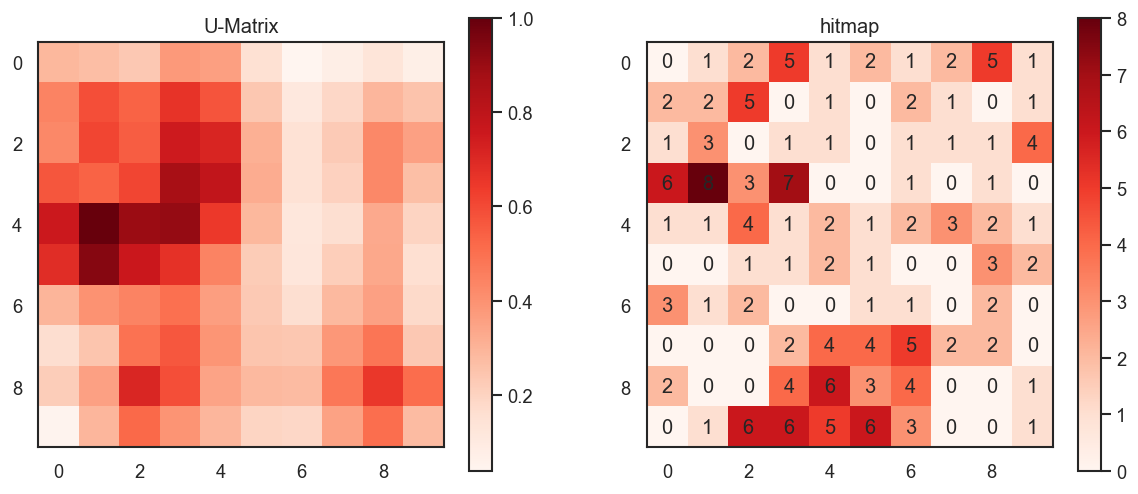

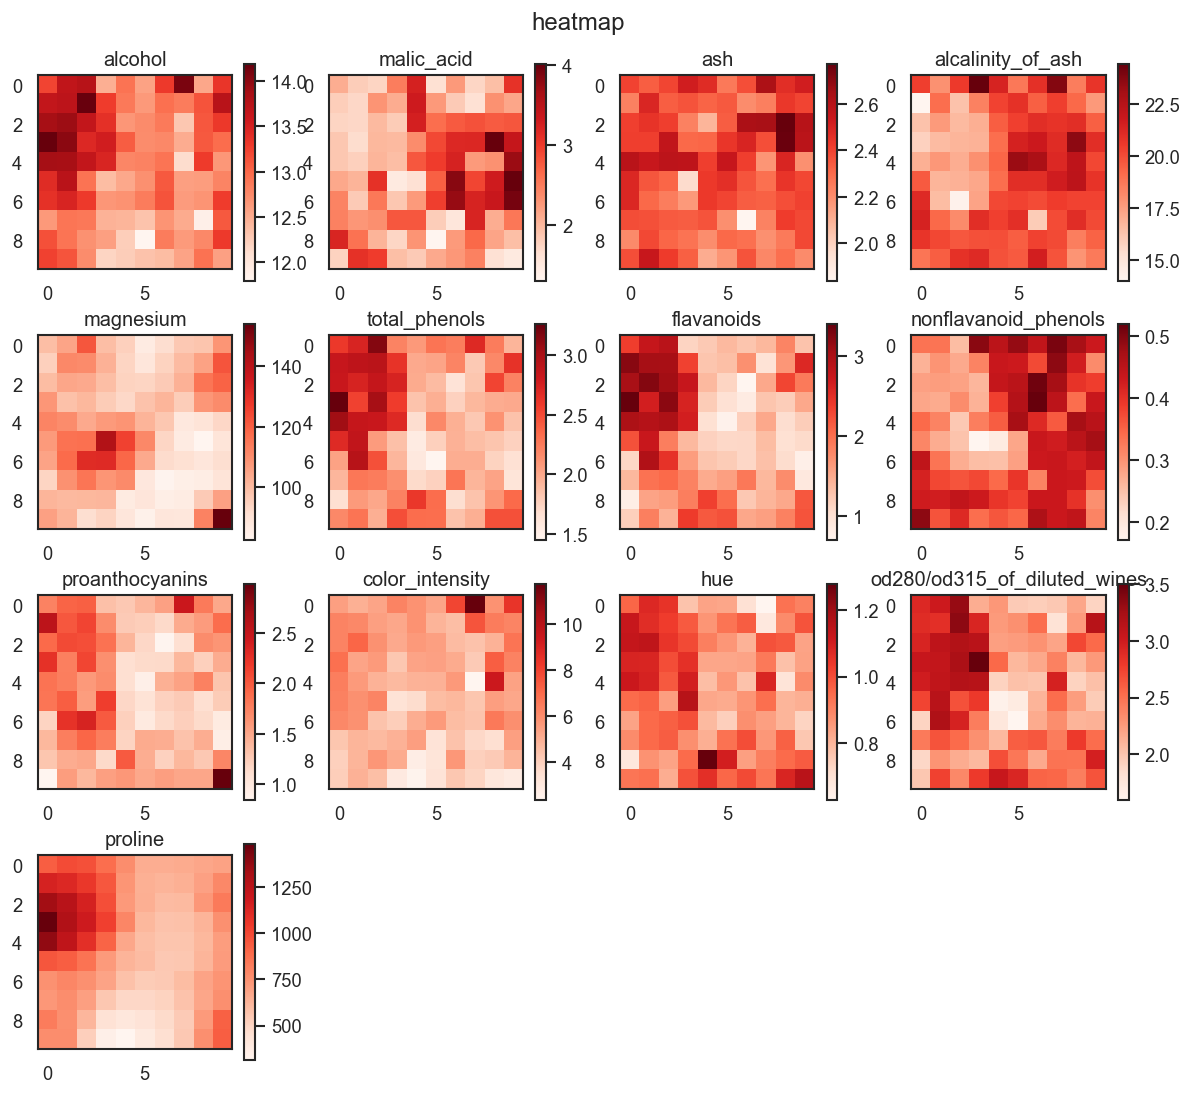

In [66]:
plot_uma_hit_hea(sw10, wine, (4, 4))

With a 10x10 grid it is already possible to distinguish two classes of neuron patterns.

<hr style="height:10px;border-width:0;background-color:blue">

### Grid 15x15

In [46]:
sw15 = MiniSom(15, 15, dataw.shape[1], random_seed = 123)
sw15.random_weights_init(dataw)
train_error = manual_random_training(sw15, dataw, 1000)
print_error(sw15, dataw)

quantization_error: 10.138035841876905
topographic_error: 0.7752808988764045


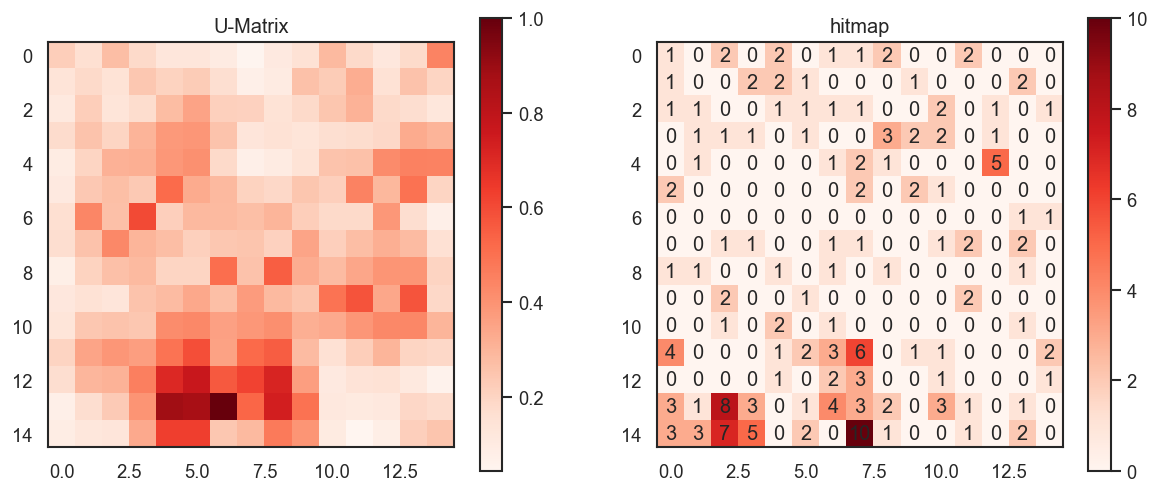

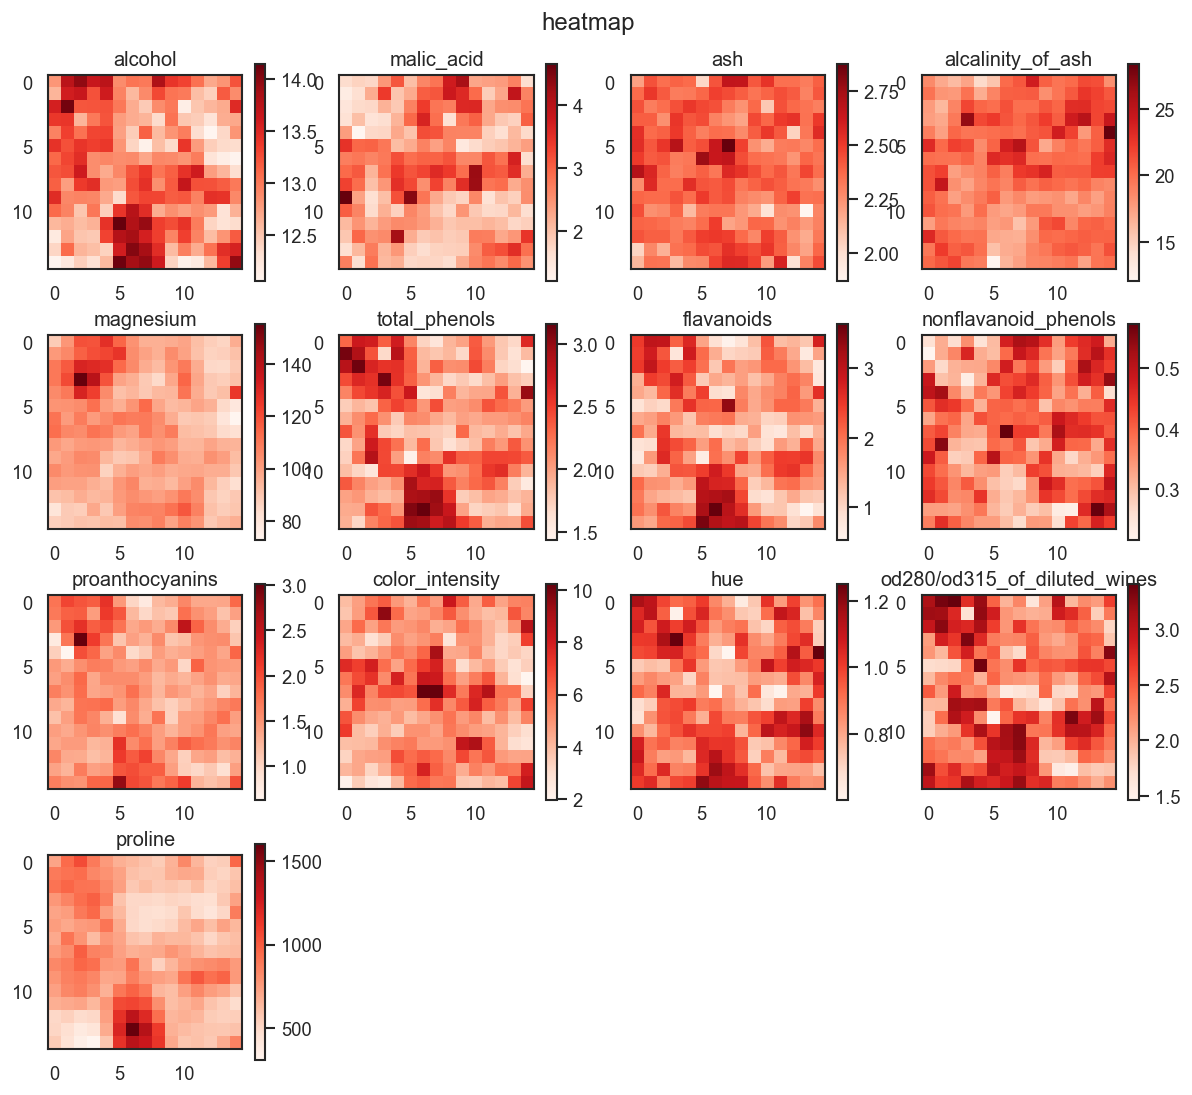

In [67]:
plot_uma_hit_hea(sw15, wine, (4, 4))

With a 15x15 grid it is possible to distinguish several classes of neuron patterns.

<hr style="height:10px;border-width:0;background-color:green">

## Sigma variation

### Sigma 0.5

In [48]:
sds5 = MiniSom(10, 10, dataw.shape[1],
              sigma=0.5,
              learning_rate=0.7,
              activation_distance="euclidean",
              topology="hexagonal",
              neighborhood_function="gaussian",
              random_seed=123)
sds5.train(dataw, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 24.215229914564123


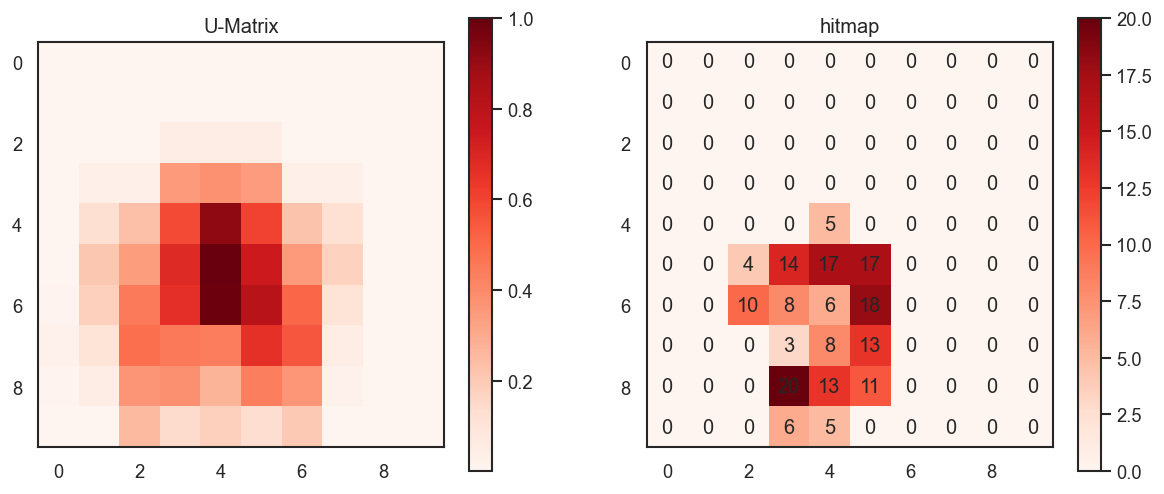

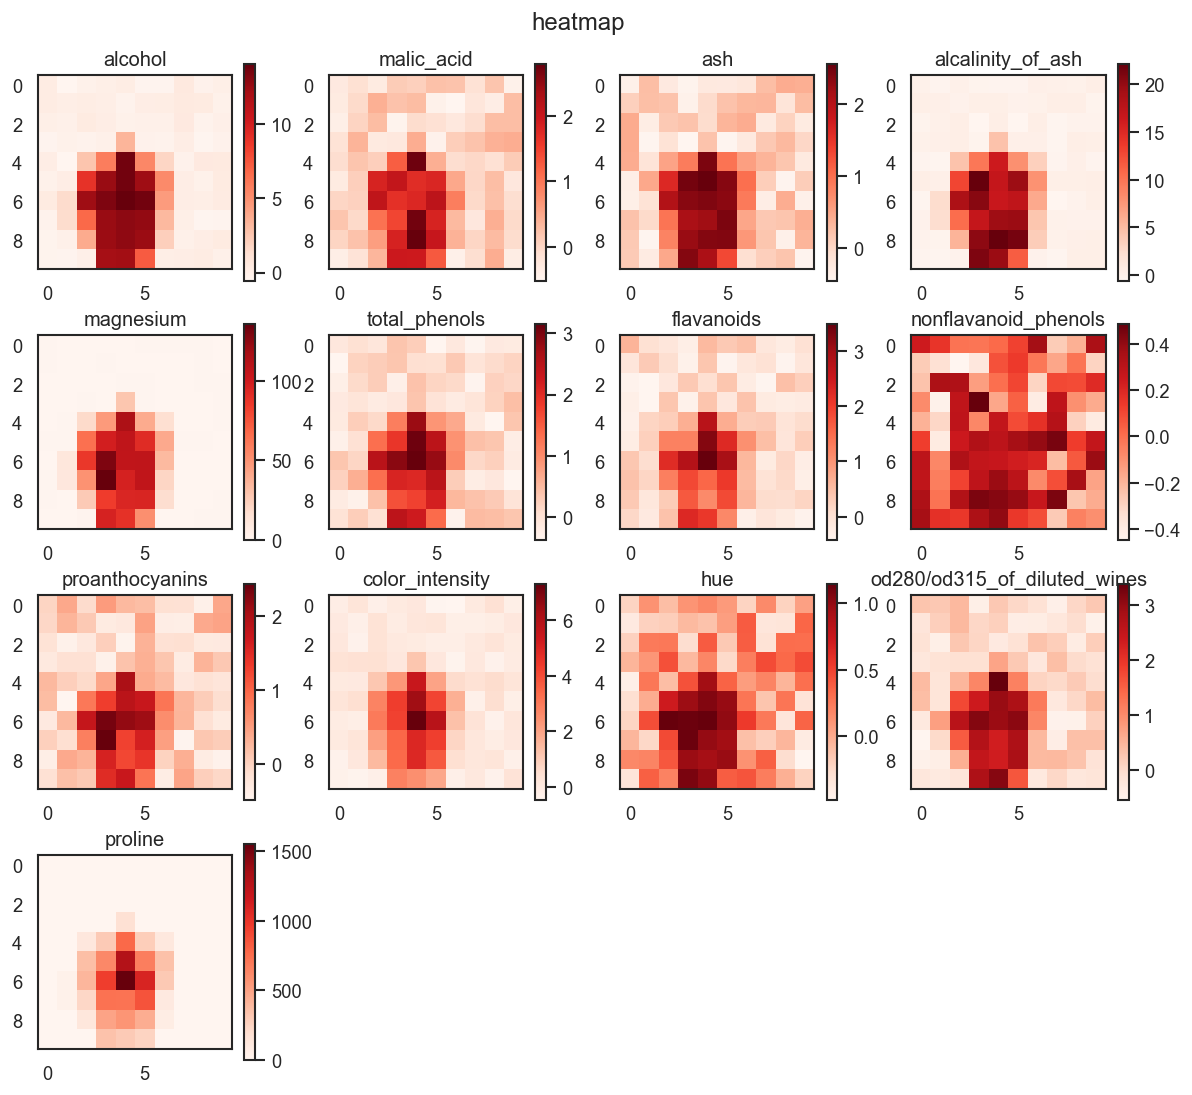

In [49]:
plot_uma_hit_hea(sds5, wine, (4, 4))

With a sigma of 0.5 a class of neuron patterns is well defined.

<hr style="height:10px;border-width:0;background-color:blue">

### Sigma 3

In [50]:
sds3 = MiniSom(10, 10, dataw.shape[1],
              sigma=3,
              learning_rate=0.7,
              activation_distance="euclidean",
              topology="hexagonal",
              neighborhood_function="gaussian",
              random_seed=123)
sds3.train(dataw, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 15.494390783149022


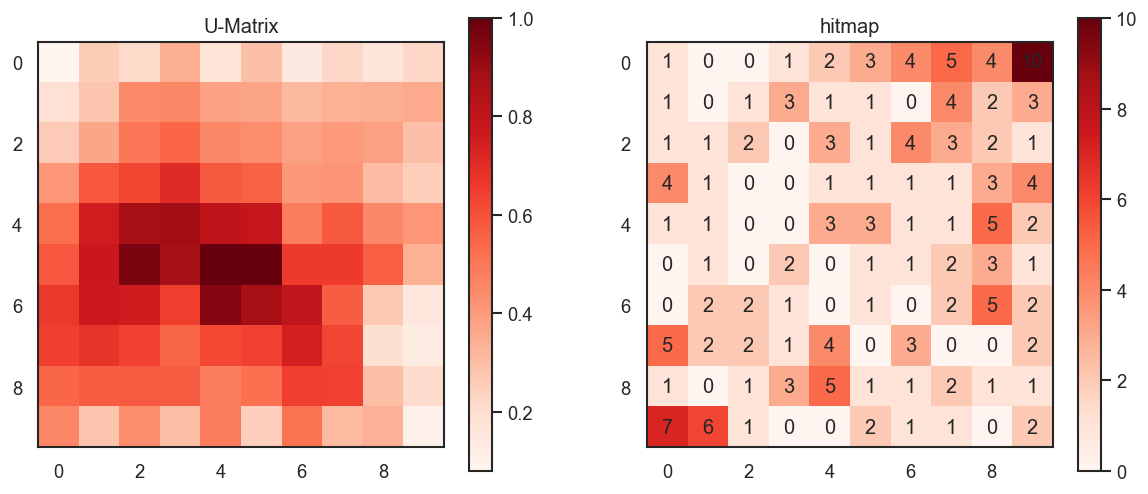

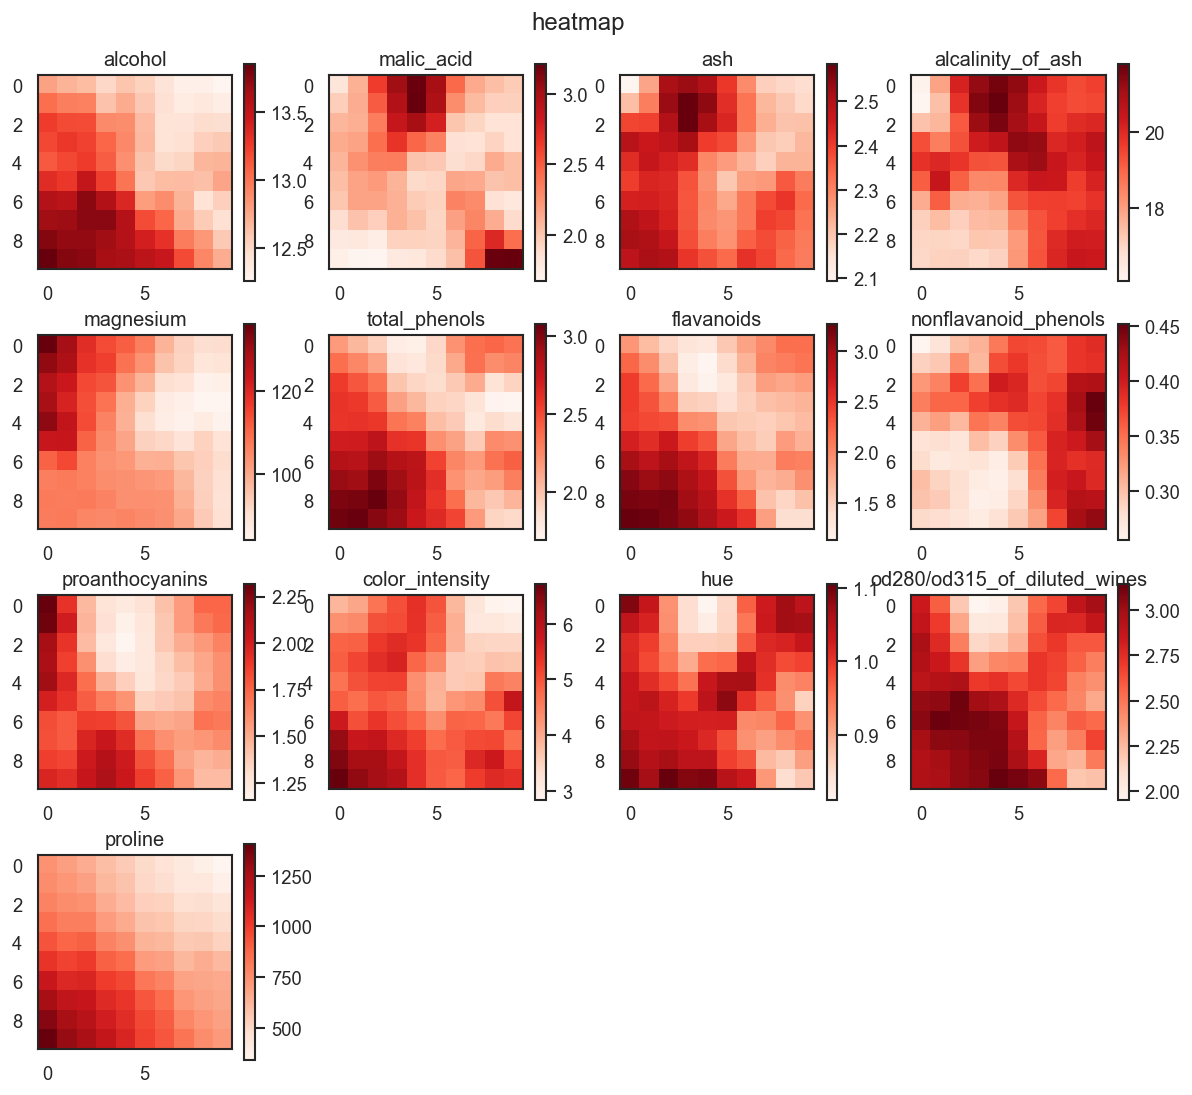

In [51]:
plot_uma_hit_hea(sds3, wine, (4, 4))

With a sigma of 3 it is already possible to identify some classes of neuron patterns.

<hr style="height:10px;border-width:0;background-color:blue">

### Sigma 9

In [52]:
sds9 = MiniSom(10, 10, dataw.shape[1],
              sigma=9,
              learning_rate=0.7,
              activation_distance="euclidean",
              topology="hexagonal",
              neighborhood_function="gaussian",
              random_seed=123)
sds9.train(dataw, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 34.70649336915737


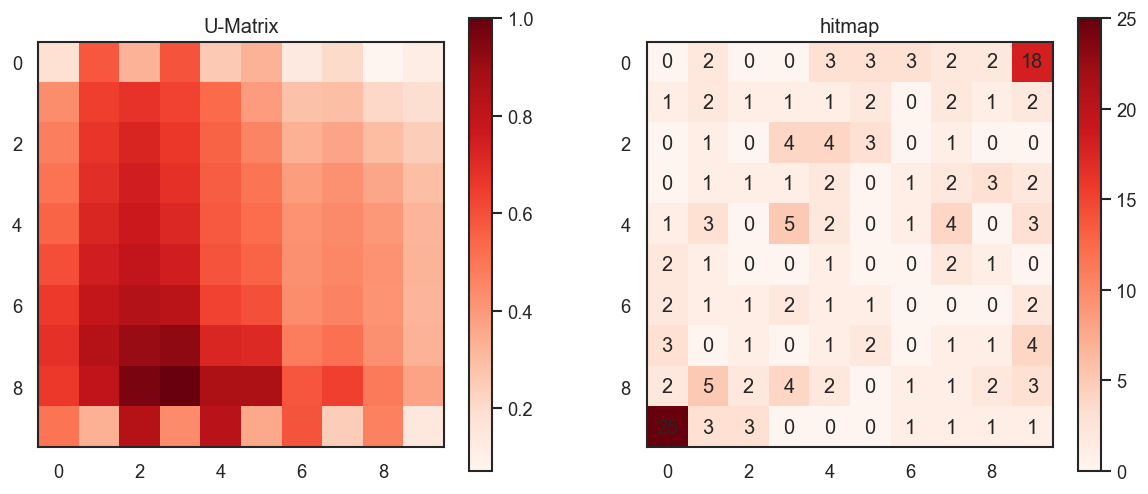

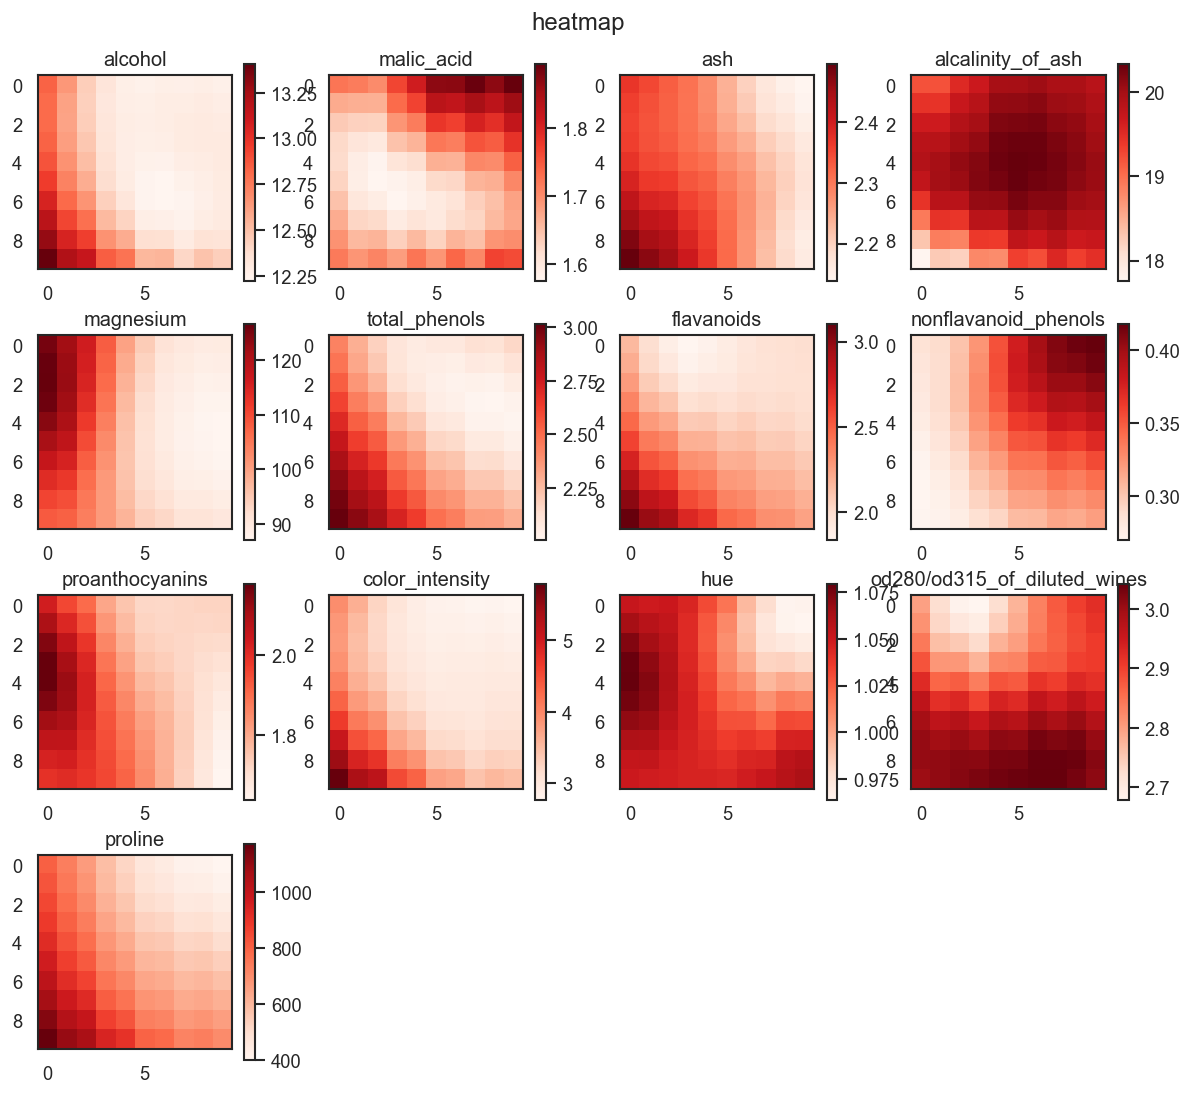

In [53]:
plot_uma_hit_hea(sds9, wine, (4, 4))

With a sigma of 9, two classes of neuron patterns are clearly visible.

<hr style="height:10px;border-width:0;background-color:green">

## Learning rate (LR)

### LR = 0.5

In [54]:
sda5 = MiniSom(10, 10, dataw.shape[1],
              sigma=1.5,
              learning_rate=0.5,
              activation_distance="euclidean",
              topology="hexagonal",
              neighborhood_function="gaussian",
              random_seed=123)
sda5.train(dataw, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 10.487236138395835


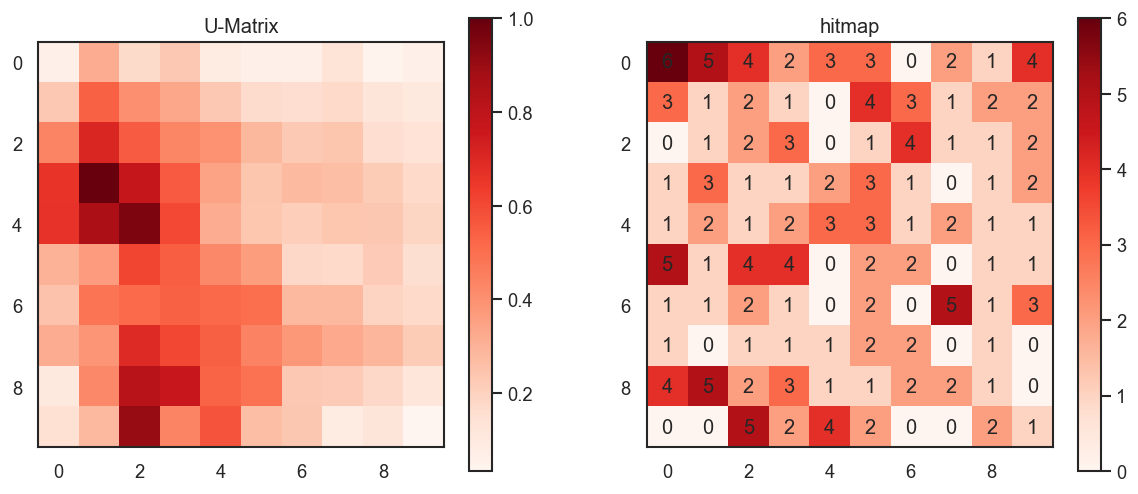

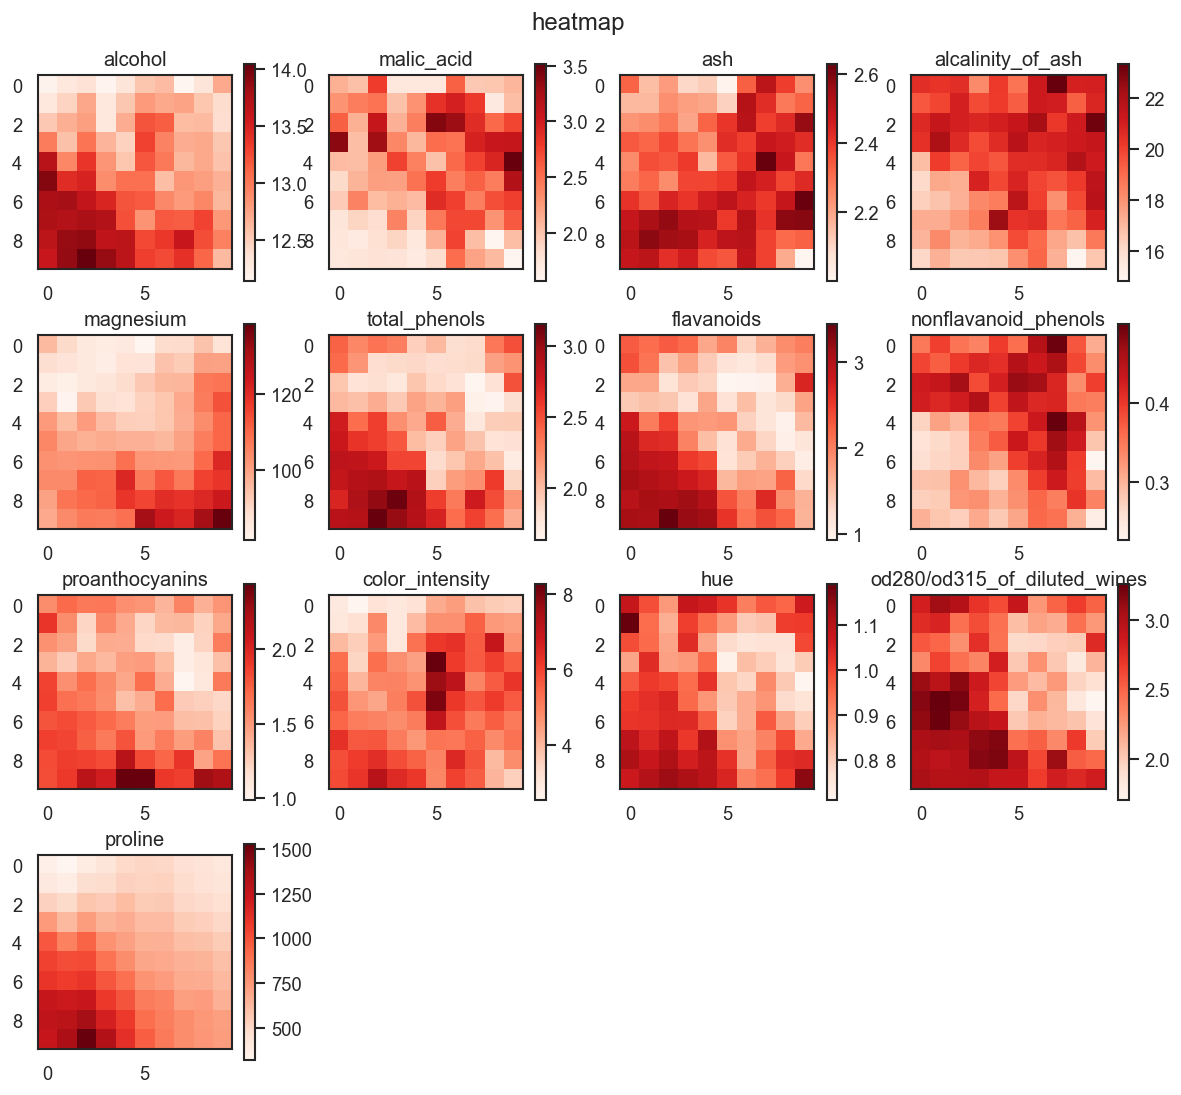

In [55]:
plot_uma_hit_hea(sda5, wine, (4, 4))

With a learning rate of 0.5, two classes of neurons stand out.

<hr style="height:10px;border-width:0;background-color:blue">

### LR = 1

In [56]:
sda1 = MiniSom(10, 10, dataw.shape[1],
              sigma=1.5,
              learning_rate=1,
              activation_distance="euclidean",
              topology="hexagonal",
              neighborhood_function="gaussian",
              random_seed=123)
sda1.train(dataw, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 9.820644564737226


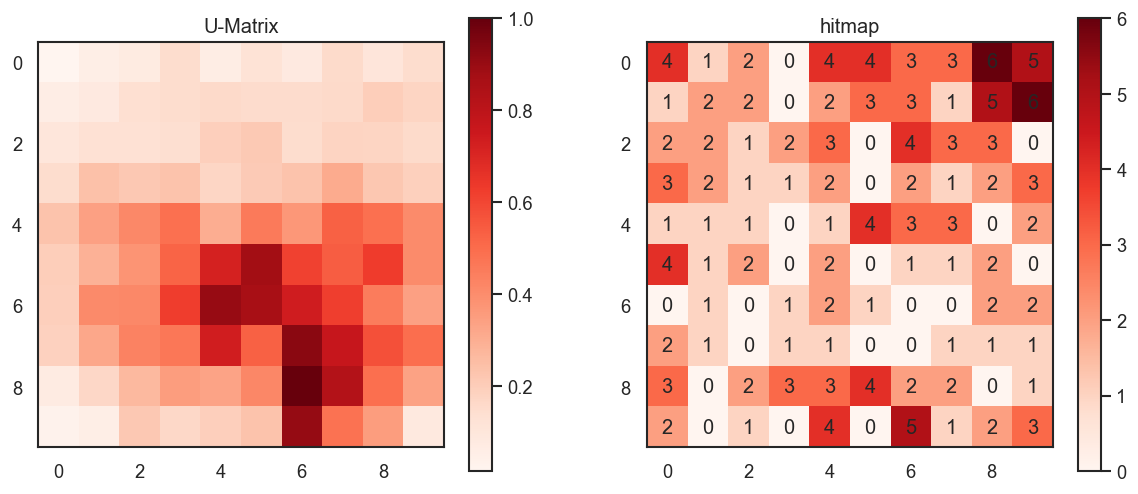

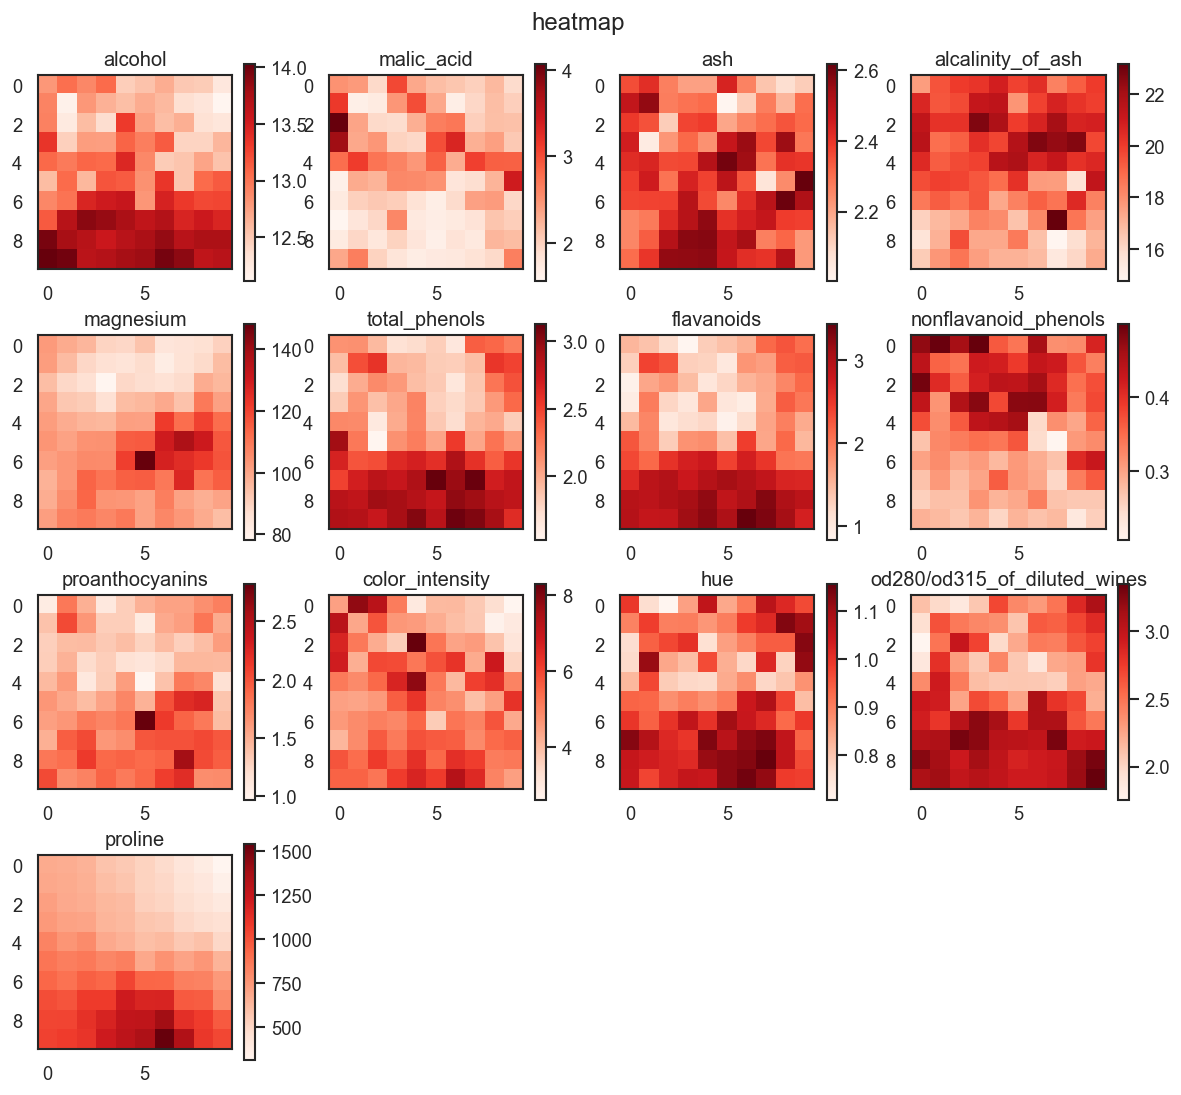

In [57]:
plot_uma_hit_hea(sda1, wine, (4, 4))

With a learning rate of 1, two classes of neurons are still visible.

<hr style="height:10px;border-width:0;background-color:blue">

### LR = 3

In [58]:
sda3 = MiniSom(10, 10, dataw.shape[1],
              sigma=1.5,
              learning_rate=3,
              activation_distance="euclidean",
              topology="hexagonal",
              neighborhood_function="gaussian",
              random_seed=123)
sda3.train(dataw, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 10.478460275428183


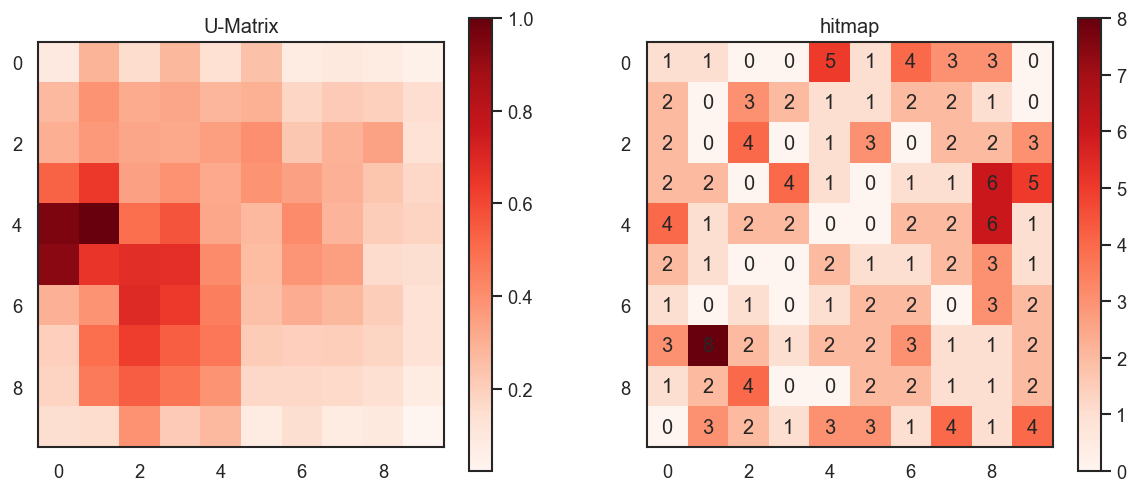

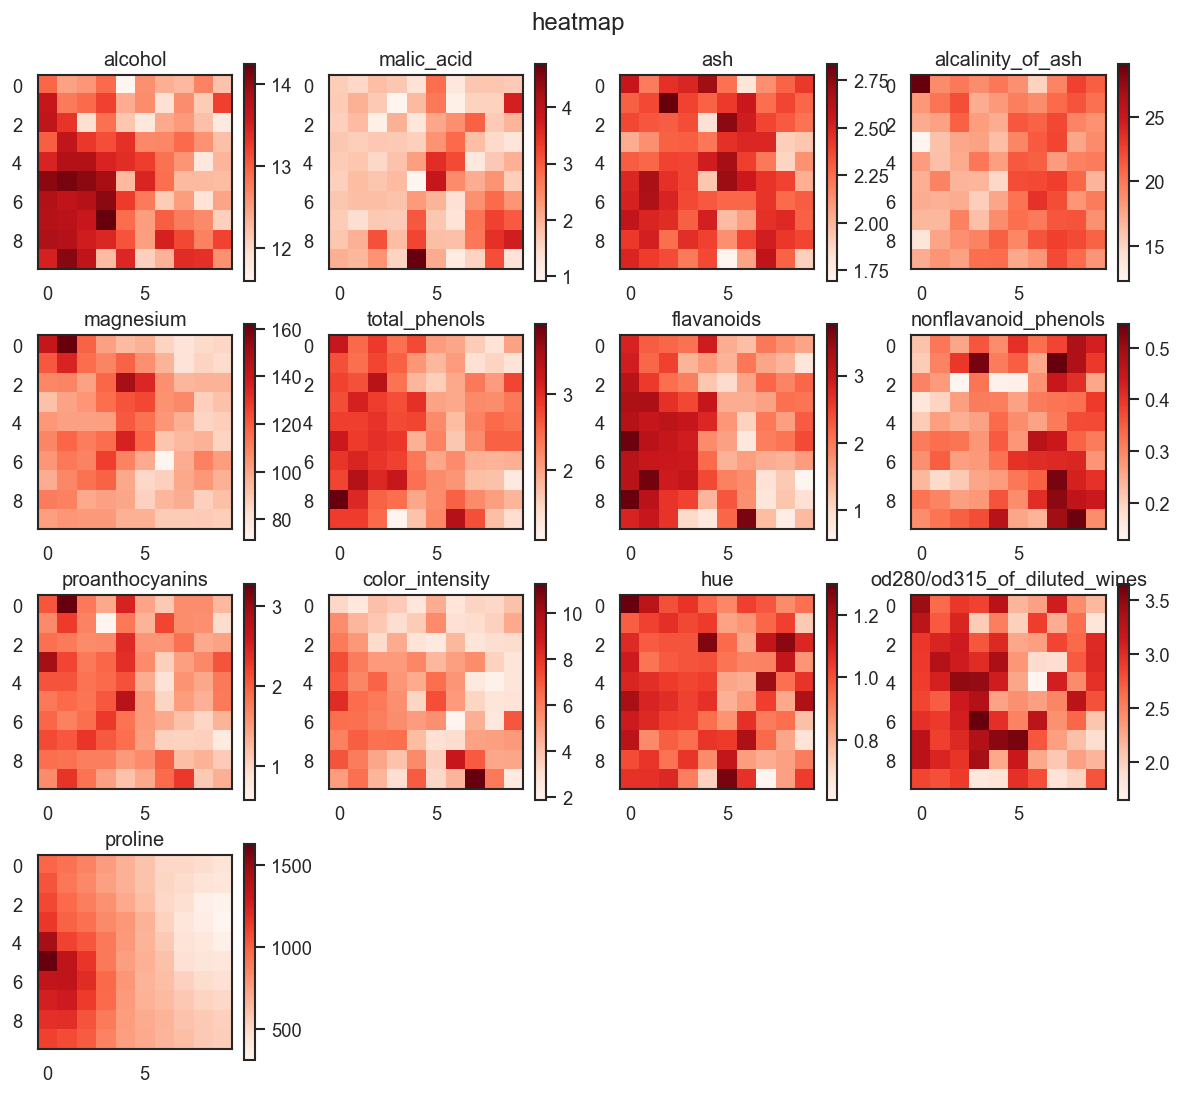

In [59]:
plot_uma_hit_hea(sda3, wine, (4, 4))

With a learning rate of 3, a neuron class is visible.

<hr style="height:10px;border-width:0;background-color:green">

## Training iterations

### Training 100

In [60]:
sdt1 = MiniSom(10, 10, dataw.shape[1],
              sigma=1.5,
              learning_rate=.7,
              activation_distance="euclidean",
              topology="hexagonal",
              neighborhood_function="gaussian",
              random_seed=123)
sdt1.train(dataw, 100, verbose=True)

 [ 100 / 100 ] 100% - 0:00:00 left 
 quantization error: 23.043348008144097


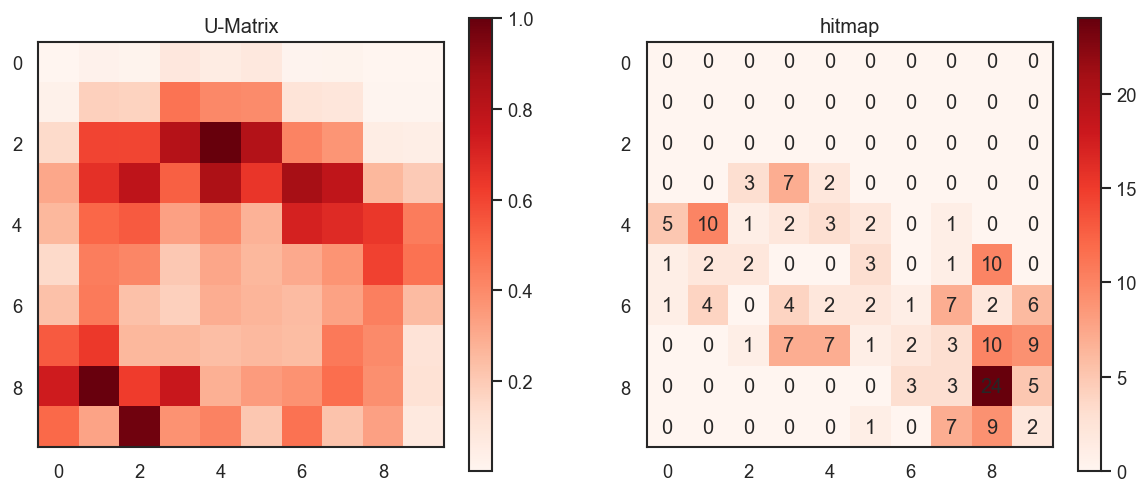

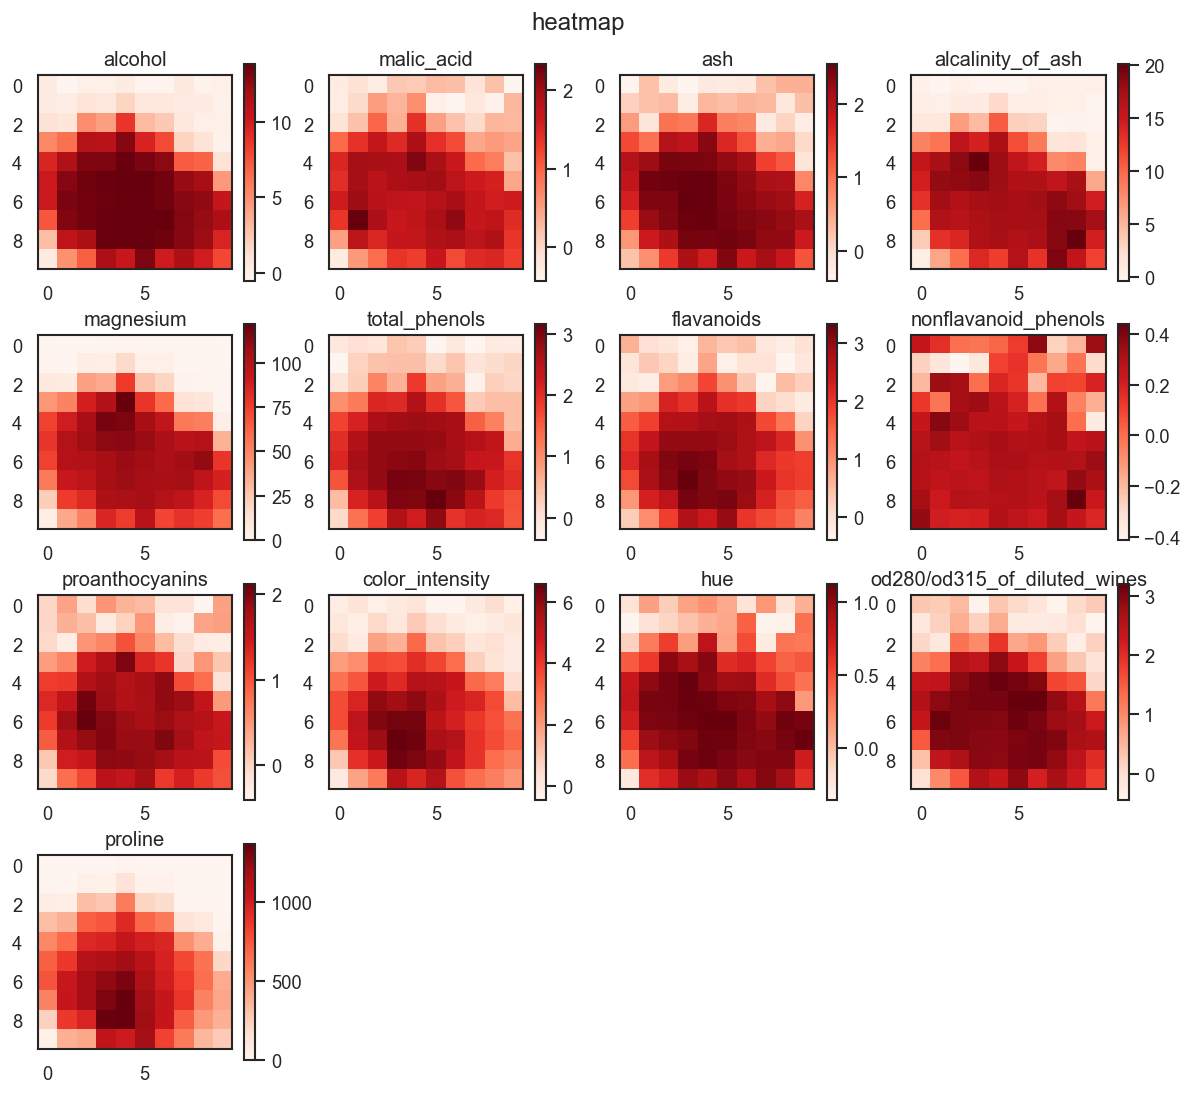

In [61]:
plot_uma_hit_hea(sdt1, wine, (4, 4))

With 100 iterations of training, there are many neurons without association with the input data.

<hr style="height:10px;border-width:0;background-color:blue">

### Training 500

In [68]:
sdt5 = MiniSom(10, 10, dataw.shape[1],
              sigma=1.5,
              learning_rate=.7,
              activation_distance="euclidean",
              topology="hexagonal",
              neighborhood_function="gaussian",
              random_seed=123)
sdt5.train(dataw, 500, verbose=True)

 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 10.994327448816415


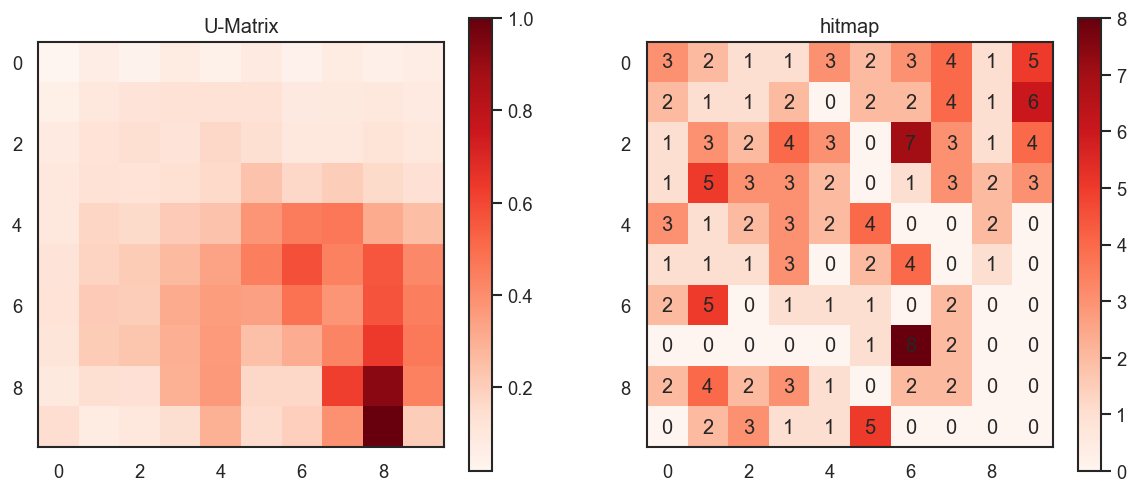

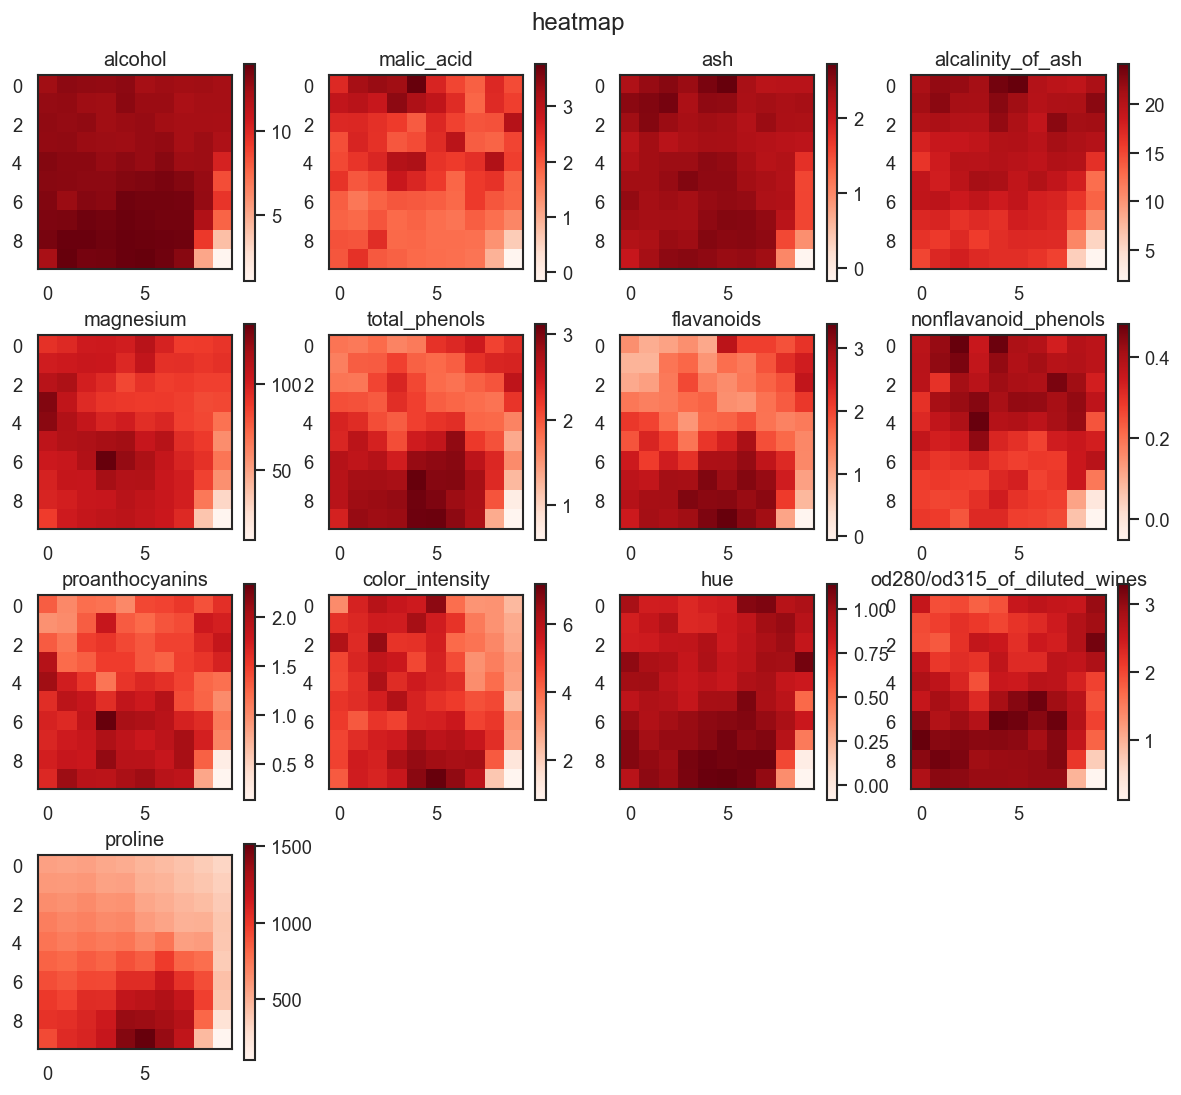

In [69]:
plot_uma_hit_hea(sdt5, wine, (4, 4))

With 500 iterations of training, the amount of neurons without association with the input data decreases, and a class of neuron patterns stands out.

<hr style="height:10px;border-width:0;background-color:blue">

### Treinamento 2000

In [70]:
sdt2 = MiniSom(10, 10, dataw.shape[1],
              sigma=1.5,
              learning_rate=.7,
              activation_distance="euclidean",
              topology="hexagonal",
              neighborhood_function="gaussian",
              random_seed=123)
sdt2.train(dataw, 2000, verbose=True)

 [ 2000 / 2000 ] 100% - 0:00:00 left 
 quantization error: 9.956229866871471


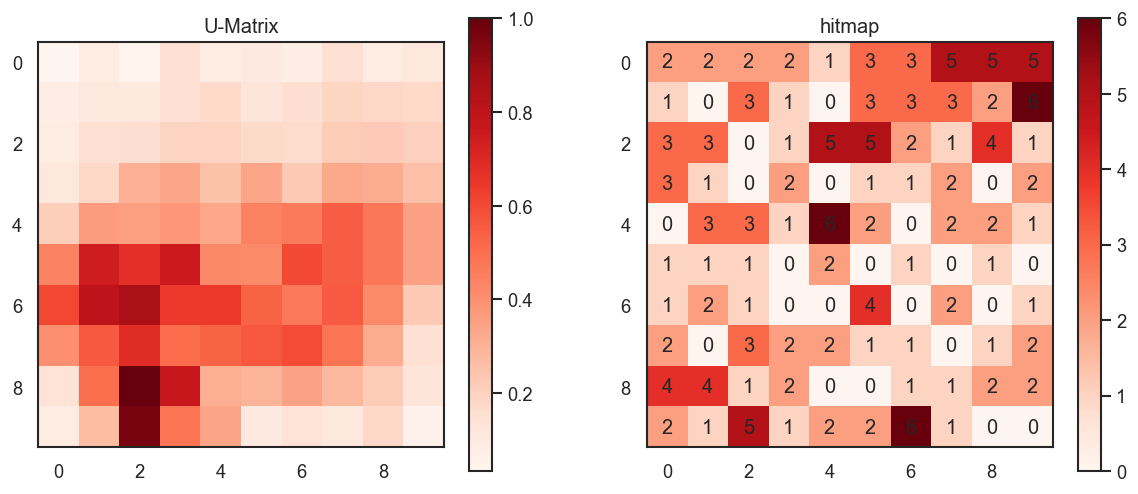

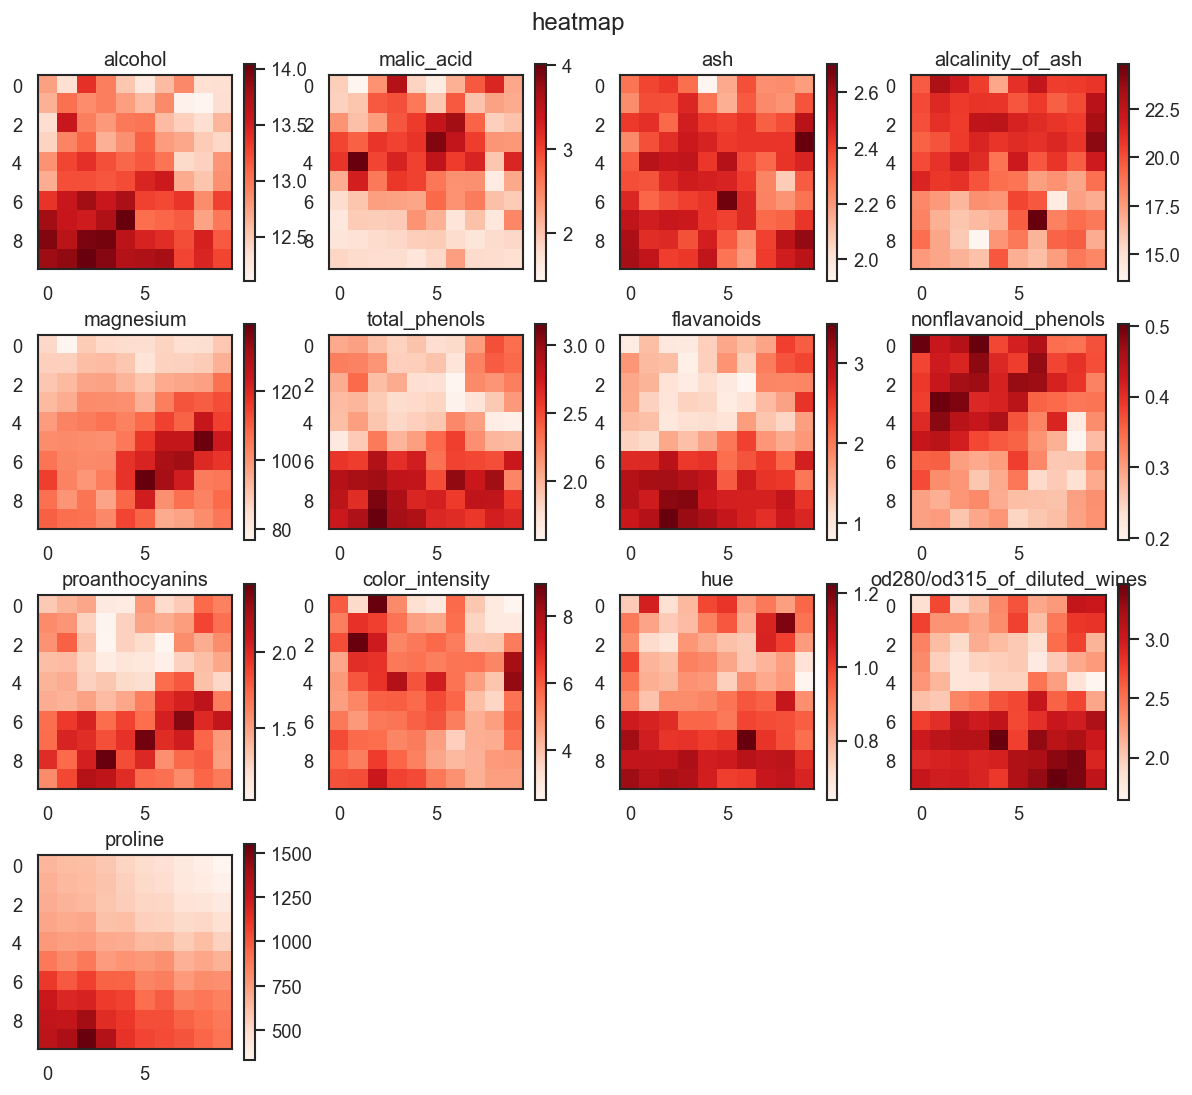

In [71]:
plot_uma_hit_hea(sdt2, wine, (4, 4))

With 2000 iterations, the number of neuron pattern classes increases.

<hr style="height:10px;border-width:0;background-color:red">

# OTHER ANALYSIS

Quantization and topographic errors are used to evaluate the quality of the feature map obtained for training the sound network.

The quantization error is the average difference of the input samples compared to their corresponding winning neurons. It evaluates the accuracy of the represented data, and is best when the value is smaller.

The topographic error evaluates the preservation of the topology. Indicates the number of data samples with the first and second best matching units not being adjacent. The lower value, the better.

## Quantization and topography error

### Dataset Digits

Analysis varying the learning rate.

In [79]:
digits = load_digits()
datad = scale(digits.data)
df_learning_rate, models_test = learning_rate([0.05, 0.1, 0.5, 0.7, 0.9, 1.2], datad)

/opt/anaconda3/envs/tf/lib/python3.9/site-packages/minisom.py:513: RuntimeWarning: invalid value encountered in sqrt


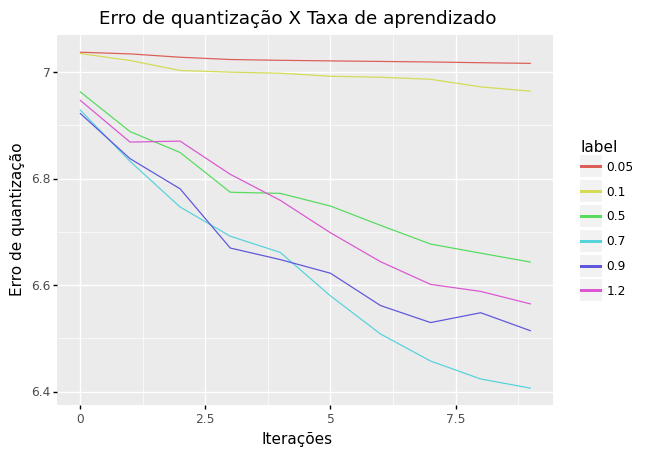

<ggplot: (8758688914417)>

In [80]:
(
    ggplot(
        df_learning_rate,
        aes(x="df_learning_rate.index", y="qerror", color="label"),
    )
    + geom_line()
    + xlab("Iterations")
    + ylab("Quantization error")
    + ggtitle("Quantization Error X Learning Rate")
)

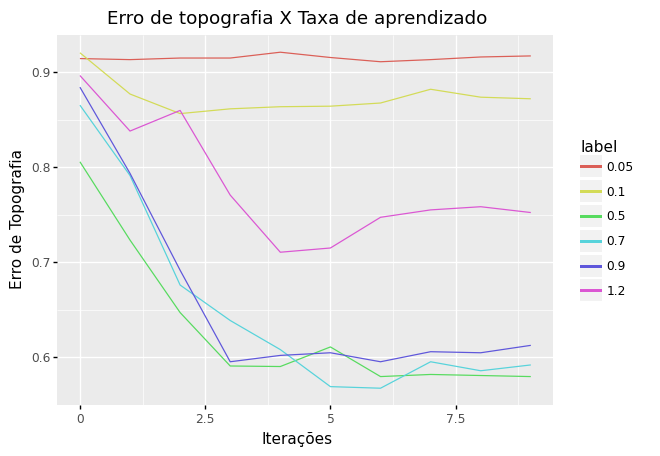

<ggplot: (8758687557117)>

In [81]:
(
    ggplot(
        df_learning_rate,
        aes(x="df_learning_rate.index", y="terror", color="label"),
    )
    + geom_line()
    + xlab("Iterations")
    + ylab("Topography Error")
    + ggtitle("Topography error X Learning rate")
)

The graphs show that the learning rate of 0.7 had the smallest errors, both in terms of quantization and topography.

### Dataset Wine

In [83]:
wine = load_wine()
dataw = wine.data

In [83]:
df_learning_rate, models_test = learning_rate([0.05, 0.1, 0.5, 0.7, 0.9, 1.2], dataw)

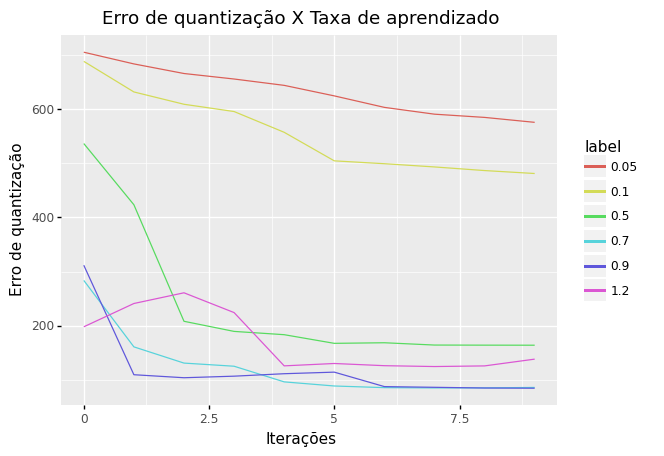

<ggplot: (8758688041174)>

In [77]:
(
    ggplot(
        df_learning_rate,
        aes(x="df_learning_rate.index", y="qerror", color="label"),
    )
    + geom_line()
    + xlab("Iterations")
    + ylab("Quantization error")
    + ggtitle("Quantization error X Learning rate")
)

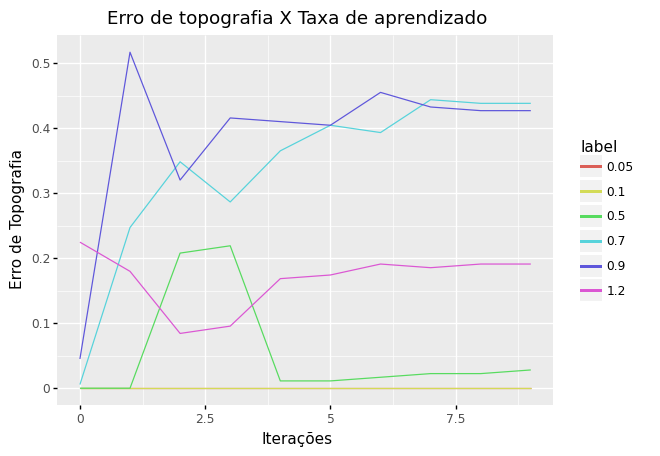

<ggplot: (8758689325596)>

In [78]:
(
    ggplot(
        df_learning_rate,
        aes(x="df_learning_rate.index", y="terror", color="label"),
    )
    + geom_line()
    + xlab("Iterations")
    + ylab("Erro de Topografia")
    + ggtitle("Erro de topografia X Learning rate")
)

For the Wine dataset, the learning rate of 0.1 obtained the smallest topography error, and that of 0.9 the smallest quantization error.

<hr style="height:10px;border-width:0;background-color:green">

## Clustering

Using the Wine dataset:

For clustering, the entire sample mapped to a specific neuron will be considered as a cluster.

To make it easier to identify each cluster, the two-dimensional indices of the neurons will be translated into one-dimensional indices:

In [84]:
som = MiniSom(1, 3, dataw.shape[1],
              sigma=.5,
              learning_rate=0.7,
              activation_distance="euclidean",
              neighborhood_function="gaussian",
              random_seed=123)
som.train(dataw, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 103.10409641606878


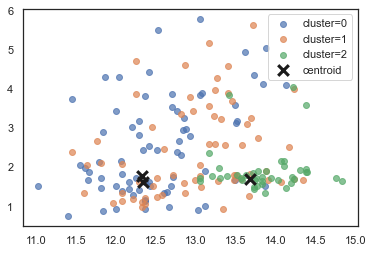

In [201]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in dataw]).T

# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(cluster_index):
    plt.scatter(dataw[cluster_index == c, 0],
                dataw[cluster_index == c, 1],
                label='cluster=' + str(c),
                alpha=.7)

# plotting centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0],
                centroid[:, 1],
                marker='x',
                s=5,
                linewidths=15,
                color='k',
                label='centroid')
plt.legend();

In the generated map, it is possible to identify two clusters (centroids) that overlap, and a third separated, in such a way that two patterns are distinguished, one on each side.

<hr style="height:10px;border-width:0;background-color:green">

## Outlier Detection 

In this analysis, two clusters will be created, with a percentage of 35% of outliers (atypical points).

It is expected that samples distant from the two clusters will be labeled as outliers.

In [88]:
som = MiniSom(2, 1, dataw.shape[1],
              sigma=1,
              learning_rate=0.5,
              neighborhood_function="triangle",
              random_seed=123)
som.train(dataw, 100, random_order=False, verbose=True)

 [ 100 / 100 ] 100% - 0:00:00 left 
 quantization error: 229.9496624830705


In [89]:
outliers_percentage = 0.35
quantization_errors = np.linalg.norm(som.quantization(dataw) - dataw, axis=1)
error_treshold = np.percentile(quantization_errors, 
                               100*(1-outliers_percentage)+5)
is_outlier = quantization_errors > error_treshold

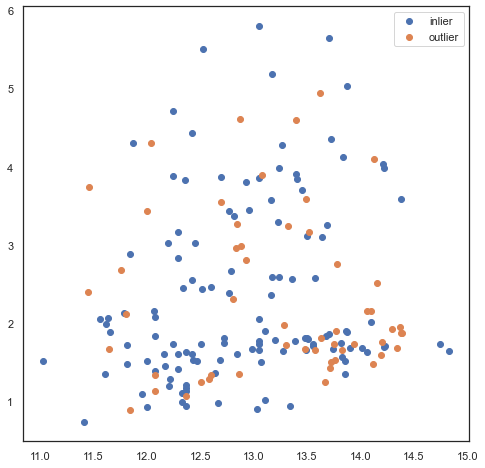

In [90]:
plt.figure(figsize=(8, 8))
plt.scatter(dataw[~is_outlier, 0], dataw[~is_outlier, 1],
            label='inlier')
plt.scatter(dataw[is_outlier, 0], dataw[is_outlier, 1],
            label='outlier')
plt.legend()
#plt.savefig('resulting_images/som_outliers_detection.png')
plt.show()

# CONCLUSIONS

This work used the SOM network and two datasets, varying parameters such as grid, sigma, learning rate, training iterations, and visualizing the results through graphs and maps.

One of the characteristics observed is that the sound network requires adjustments so that the neuron weights are necessary and sufficient to group the inputs, in such a way that the groupings found in the maps are accurate and informative. This is the case, for example, when a neuron appears in the map without any association with data points in the input dataset.

One of the advantages of the network is to be able to easily observe characteristics and similarity patterns in the dataset. Other advantages are: being relatively fast for large datasets, visualizing relatively complex data, and having a simple algorithm allowing adaptation as needed.

One of the disadvantages is that it requires a relatively large amount of data. Also, once it detects patterns, it may not behave as expected if the data represents a single cluster.

# REFERENCES

- http://github.com/JustGlowing/minisom
- http://umap-learn.readthedocs.io
- http://scipy-lectures.org/packages/scikit-learn/auto_examples/plot_digits_simple_classif.html